# Analise Exploratória de Dados do Censo da Educação Superior 2018/2020 

**========================================================================================================================**
**========================================================================================================================**
**========================================================================================================================**
**========================================================================================================================**

# *PROBLEMAS DE NEGÓCIO?*

## Qual a tendência de cursos com maior demanda para Instituições de Ensino Superior Privadas?

## Qual a tendência de volume de profissionais que estão sendo formados e inseridos no mercado de trabalho? essa tendência esá acompanhando a demanda por profissionais do mercado?

**========================================================================================================================**
**========================================================================================================================**
**========================================================================================================================**
**========================================================================================================================**

# 1) Premissa Técnica inicial

### Os dados utilizados para essa análise estão disponíveis no site do Inep os Microdados do Censo da Educação Superior 2018 (DM_IES, DM_CURSO, DM_DOCENTE, DM_ALUNO, DM_LOCAL_OFERTA e TB_AUX_AREA_OCDE) em formato CSV delimitados por Pipe ( | ). Os arquivos encontram-se compactados (em formato .zip) pelo software 7-zip. 

In [16]:
#Importação das Bibliotecas utilizadas

#Tratamento e manipulação dos dados
import pandas as pd
import numpy as np

#Consultas ao banco de dados
import sqlite3

#Represetações gráficas
import seaborn as sn
import matplotlib.pyplot as plt

#Outras
import random
import glob
import scipy.stats as stats

## Ao invés de ler os arquivos diretamente em seu formato csv optei por converter esses arquivos em um banco de dados com o SQLite3.
Ao criar um banco de dados e acessá-lo através de consultas eu segmento a minha busca e diminuo o peso de processamento da minha máquina.

In [ ]:
def convert_csv_to_sql(path_to_data, db_name, chunksize):
    '''
    Função para conversão de arquivos csv em banco de dados sqlite3.
    
    INPUTS:
        path_name : str
            Caminho para os dados em formato csv a serem convertidos.
            
        db_name: str
            Nome do banco de dados a receber os dados
            
        chunksize : int
            Tamanho do lote de carregamento do arquivo csv.
    '''
    # Cria conexao/banco de dados
    db = sqlite3.connect(db_name)

    # Lê todos os arquivos do caminho especificado em formato csv 
    files = glob.glob(f'{path_to_data}/*.csv')
    # Para cada um dos arquivos
    for file in files:

        # Define o nome da tabela como sendo o nome do arquivo sem o .csv
        table_name = file.split('\\')[-1].split('.CSV')[0]

        # Carrega o arquivo indicado em chunks (lotes) de forma
        # a permitir operação com dataframes grandes demais
        df_chunks = pd.read_csv(file, sep='|', encoding='latin1', chunksize=chunksize)

        # Para cada lote ("pedaço") do dataframe
        for df in df_chunks:

            # Escreve o pedaço no banco
            df.to_sql(
                name=table_name, # Define o nome da tabela a receber as informações (ou ser criada)
                index=False, # Não escreve o índice do dataframe na tabela
                if_exists='append', # Se a tabela já existir, adiciona as informações abaixo das existentes
                con=db # Define em qual banco os dados serão inseridos
            )

In [ ]:
# Utilizando função para conversão dos csvs em banco de dados sqlite

convert_csv_to_sql('D:/DATA D/caiof/CURSOS/CURSO - DATA SCIENCE - DIGITAL HOUSE/Modulo 1/Aula27_20220427_Desafio_1/dados', 'desafio_1.db', chunksize=100000)

## Estabelecendo a conexão com o banco de dados criado e ativando o cursor csqlite

In [3]:
# Conecta ao banco
db = sqlite3.connect('desafio_1.db')
#Ativando o curso csqlite
csqlite = db.cursor()


## Para facilitar o processo de acesso ao banco criei uma função para encerrar a conexão com o banco e desativar o cursor, após concluir as atividades

In [4]:
#Criando fórmula para fechar o acesso ao bando e desativar o cursor. É fundamental sempre, após encerrar suas atividades fechar
#....o acesso ao banco e evitar assim vulnerabilidades, bem como exceção de conexões ao banco.

def close_access_database(db_name,cursor_name):
    '''
    Função para desativar o cursor csqlite e fechar a conexão com o banco
    INPUTS:
        db_name: str
        Nome do banco de dados cuja conexão será fechada
        
        cursor_name: str
        Nome do cursor a ser desativado
    
    '''
    cursor_name.close()
    db_name.close()
    print('Acesso ao banco de dados fechado com sucesso')

In [24]:
close_access_database(db,csqlite)

Acesso ao banco de dados fechado com sucesso


## Os códigos rodaram perfeitamente, dessa forma foi criado uma bando de dados e cada um dos meus arquivos csv foi convertido em uma Table dentro desse banco de dados, conforme podemos verificar abaixo.

In [27]:
# Inspeciona tabelas no db

pd.read_sql_query('SELECT tbl_name FROM sqlite_master', db)

,tbl_name
0,DM_ALUNO
1,DM_CURSO
2,DM_DOCENTE
3,DM_IES
4,DM_LOCAL_OFERTA
5,TB_AUX_CINE_BRASIL
6,Cod_UF.csv
7,ESTADOS


**========================================================================================================================**
**========================================================================================================================**
**========================================================================================================================**
**========================================================================================================================**

# 2) ANÁLISE EXPLORATÓRIA DOS DADOS

# Para poder fazer qualquer análise comercial, antes é necessário entender o cenário dos dados que estamos analisando. Nesse caso é importante entender o cenário da Educação Superior no País, em 2018 e, as mudanças deste, nos anos posteriores.



In [668]:
query = """
SELECT
    strftime('%Y',
            date(
                substr( DT_INICIO_FUNCIONAMENTO, 7, 10 )
                ||'-'
                ||substr( DT_INICIO_FUNCIONAMENTO, 4, 2)
                ||'-'
                ||substr( DT_INICIO_FUNCIONAMENTO, 1, 2)
                )
            ) as Ano_inicio_funcionamento,
    COUNT(*) AS Qt_cursos
FROM
    DM_CURSO WHERE Ano_inicio_funcionamento is not null
GROUP BY
    Ano_inicio_funcionamento
HAVING
    Qt_cursos > 10
"""
df_cursos_novos_ano = pd.read_sql(query ,db)
df_cursos_novos_ano.head()

,Ano_inicio_funcionamento,Qt_cursos
0,1847,40
1,1911,18
2,1912,24
3,1923,12
4,1930,14


# Analisando temos um gráfico que nos mostra a evolução no número de Novos Cursos IES criados no país, ano a ano.

# os dados apresentados pode-se ver que, a partir de 1998 ano após ano observa-se um crescimento no número de cursos disponíveis no país. Crescimento praticamente contínuo até 2009, com anos de redução entre 2010 e 2013, uma nova alta consideravel e continua ente 2014 e 2015 e, por fim, um curva decrescente a partir de 2016 até 2018.

# Para tentar entender esse comportamento não basta a análise dos dados disponibilizados pura e simplesmente, mas a influência de fatores externos que os influenciem.


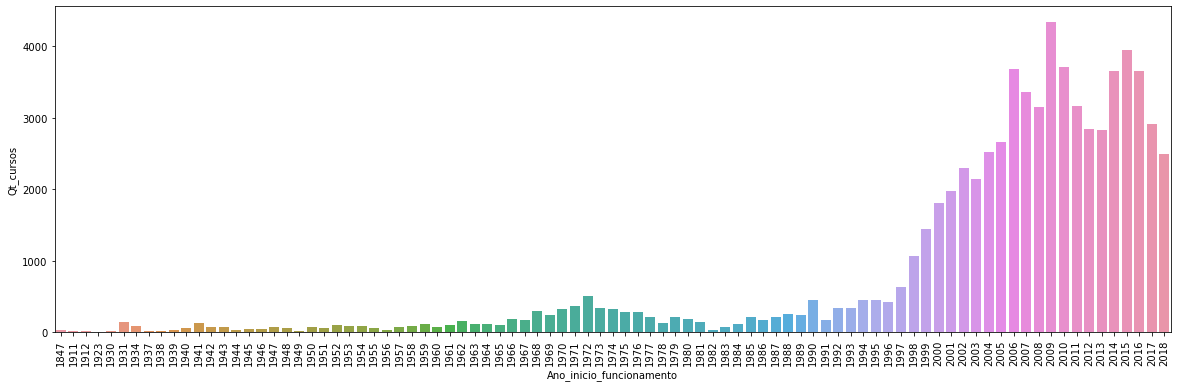

In [672]:
plt.figure(figsize = (20, 6))
s = sn.barplot(data = df_cursos_novos_ano, x = 'Ano_inicio_funcionamento', y = 'Qt_cursos')
plt.xticks(rotation = 90)
plt.show()


# Em 1999 foi lançado o Fundo de Financiamento Estudantil (FIES) e a partir do lançamento desse programa observamos um crescimento praticamente contínuo entre 1999 e 2010 no número de IES.

# Com o advento desse programa surge uma enorme demanda ainda não explorada. Pessoas que não poderiam pagar por um educação superior em uma instituição privada e, que não conseguiu a vaga em institução pública, poderiam agora ter essa possibilidade, logo, o interesse surge. Com o governo como garantidor dessa nova demanda, passa a surgir a necessidade de maior oferta, dai o crescimento exponencial de IES Privadas dai em diante. 

In [19]:
df_historico_matriculas = pd.read_csv('D:/caiof/MATERIAL DE ESTUDO OUTROS/DATA SCIENCE/CURSO - DATA SCIENCE - DIGITAL HOUSE/Modulo 1/Aula27_20220427_Desafio_1/Dados Matriculas 2080-2018 e contratos fies.csv', sep=';')

In [20]:
df_historico_matriculas.head()

,Ano,Matriculas IES Publicas,Matriculas IES Privadas,Total matriculas IES Brasil,% Matriculas IES Publicas,% Matriculas IES Privadas,Vagas ofertadas,Crescimento vagas ofertadas,Novas vagas ofertadas,Contratos ativos,Crescimento % ano anterior
0,1980,492232,885054,1377286,"35,74%","64,26%",NaN,NaN,NaN,NaN,NaN
1,1981,535810,850982,1386792,"38,64%","61,36%",NaN,NaN,NaN,NaN,NaN
2,1982,548388,859599,1407987,"38,95%","61,05%",NaN,NaN,NaN,NaN,NaN
3,1983,576689,862303,1438992,"40,08%","59,92%",NaN,NaN,NaN,NaN,NaN
4,1984,571879,827660,1399539,"40,86%","59,14%",NaN,NaN,NaN,NaN,NaN


Text(0.5, 1.0, 'Matriculas no país')

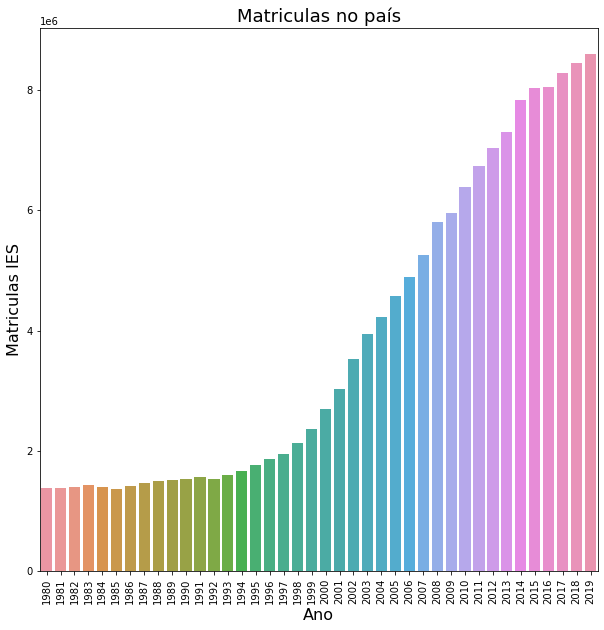

In [28]:
plt.figure(figsize=(10, 10))

#Plotando o gráfico com o uso do método barplot da lib seaborn
s = sn.barplot(x= df_historico_matriculas['Ano'], y= df_historico_matriculas['Total matriculas IES Brasil'])

#Renomeando as labels dos eixos X e Y, bem como mudando o tamanho da font
plt.xlabel("Ano", fontdict={'fontsize':16})
plt.ylabel("Matriculas IES", fontdict={'fontsize':16})

plt.xticks(rotation = 90)


#Criando o título do gráfico
plt.title('Matriculas no país', fontdict={'fontsize': 18})


Text(0.5, 1.0, 'Vagas Ofertadas Fies - ano a ano')

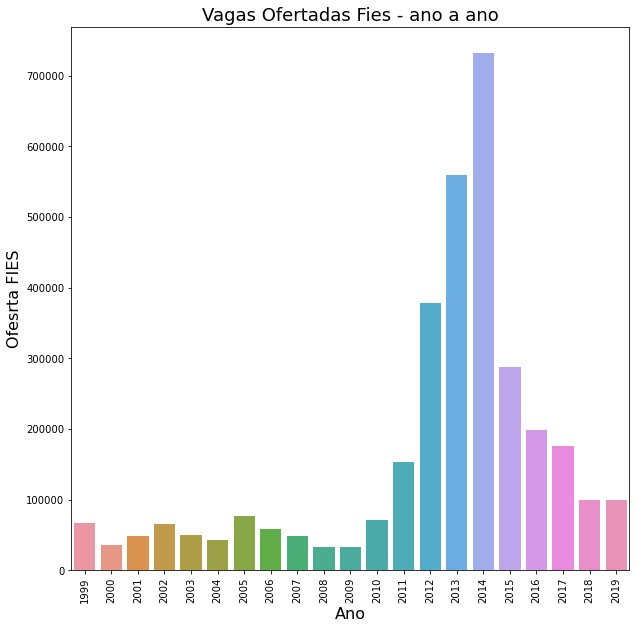

In [29]:
plt.figure(figsize=(10, 10))

#Plotando o gráfico com o uso do método barplot da lib seaborn
s = sn.barplot(data = df_historico_matriculas[df_historico_matriculas['Ano'] > 1998], x= 'Ano', y= 'Novas vagas ofertadas')

#Renomeando as labels dos eixos X e Y, bem como mudando o tamanho da font
plt.xlabel("Ano", fontdict={'fontsize':16})
plt.ylabel("Ofesrta FIES", fontdict={'fontsize':16})
plt.xticks(rotation = 90)


#Criando o título do gráfico
plt.title('Vagas Ofertadas Fies - ano a ano', fontdict={'fontsize': 18})



# A primeira informação que julgo relevante ser retirada dos dados para iniciarmos essa análise é verificar quantas instituições de ensino superior existiam no pais em 2018 e quantos alunos estavam matriculados nelas.


- **INFORMAÇÃO TÉCNICA:**

Utilizaremos nesse momento a tabela DM_IES do Bando de Dados. Para fazer consultas nessa tabela utilizarei funções do pandas que me permitem utilizar querys SQL para consultar o banco. Essas consultas são retornadas como objetos do tipo DataFrames do pandas, o que me permite utilizar todas as funções de tratamento que as bibliotecas numpy e pandas me fornecem.

Nesse primeiro momento farei sucessivas consultas ao banco, para fins de aprendizado, embora fosse possível fazer apenas uma primeira consulta e criar um DataFrame completo e parcialmente tratado.

In [14]:
#Utilizei a query abaixo, na qual consultei a tabela DM_IES, especificamente as colunas CO_IES e NO_IES. Para do princípio que
#....a coluna CO_IES vão me fornecer um código único, exclusivo de cada IES, o qual figurará como minha Primary Key, no entando, por não
#....por não conhecer os dados ainda optei por buscar na consulta SQL apenas os valores distintos nessa coluna. Assim eu sei que
#....o DataFrame que me será retornado não terá valores duplicados nessa coluna.

query = """
SELECT DISTINCT(CO_IES), NO_IES
from DM_IES

"""

df_ies = pd.read_sql_query(query, db)
df_ies

,CO_IES,NO_IES
0,1,UNIVERSIDADE FEDERAL DE MATO GROSSO
1,2,UNIVERSIDADE DE BRASÍLIA
2,3,UNIVERSIDADE FEDERAL DE SERGIPE
3,4,UNIVERSIDADE FEDERAL DO AMAZONAS
4,6,UNIVERSIDADE FEDERAL DE OURO PRETO
...,...,...
2532,23410,UNIVERSIDADE ESTADUAL DA REGIÃO TOCANTINA DO M...
2533,284,FACULDADE DE MEDICINA DE ITAJUBÁ
2534,633,INSTITUTO MILITAR DE ENGENHARIA
2535,3311,Faculdade de Educação Avançada do Noroeste Cap...


In [15]:
#Optei por já armazenar o valor total de IES em uma variável, assim caso, posteriormente, precise desse valor meu código será 
#....mais simples

total_ies = df_ies['NO_IES'].count()
total_ies

2537

# Encontramo que o total de IES no Brasil em 2018 eram de 2.537, dessas como será a divisão entre instituições privadas e públicas?

- **INFORMAÇÃO TÉCNICA:**


Para sabermos quais dessas Universidades são Públicas ou Privadas temos a coluna TP_CATEGORIA_ADMINISTRATIVA, a qual classifica numericamente os tipos de instituições, no entanto essa classificação se da em 7 categorias diferente, após fazer uma análise ao dicionário de dados verificamos que apenas as 1, 2 e 3 são categorias que se enquadram como Públicas.

In [16]:
#Abaixo para categorizar se as IES são públicas ou privados, utilizei os valores da coluna 'TP_CATEGORIA_ADMINISTRATIVA' 
#....onde criei uma condição para separar tudo em 'Público' ou "Privado", por fim que fosse retornado apenas a coluna 'NO_IES' 
#....a coluna nova 'PUB_PRIV' criada durante a consulta já será retornada.

query = """
SELECT DISTINCT(CO_IES), NO_IES, 
CASE
    WHEN TP_CATEGORIA_ADMINISTRATIVA = '1' OR TP_CATEGORIA_ADMINISTRATIVA = '2' OR TP_CATEGORIA_ADMINISTRATIVA = '3' OR TP_CATEGORIA_ADMINISTRATIVA = '7' THEN 'Pública'
    ELSE 'Privada'
END AS PUB_PRIV
FROM DM_IES

"""
ies_pub_priv = pd.read_sql_query(query, db)
ies_pub_priv

,CO_IES,NO_IES,PUB_PRIV
0,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,Pública
1,2,UNIVERSIDADE DE BRASÍLIA,Pública
2,3,UNIVERSIDADE FEDERAL DE SERGIPE,Pública
3,4,UNIVERSIDADE FEDERAL DO AMAZONAS,Pública
4,6,UNIVERSIDADE FEDERAL DE OURO PRETO,Pública
...,...,...,...
2532,23410,UNIVERSIDADE ESTADUAL DA REGIÃO TOCANTINA DO M...,Pública
2533,284,FACULDADE DE MEDICINA DE ITAJUBÁ,Privada
2534,633,INSTITUTO MILITAR DE ENGENHARIA,Pública
2535,3311,Faculdade de Educação Avançada do Noroeste Cap...,Privada


In [17]:
ies_pub_priv_soma = ies_pub_priv['PUB_PRIV'].value_counts()

In [18]:
print('-='*62)
print(f'Do total de {total_ies} IES que tinhamos no país em 2018, {ies_pub_priv_soma[0]} eram\
 Instituições Públicas e {ies_pub_priv_soma[1]} tratavam-se de Instituições Privadas')
print('-='*62)

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Do total de 2537 IES que tinhamos no país em 2018, 2238 eram Instituições Públicas e 299 tratavam-se de Instituições Privadas
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


In [19]:
ies_pub_priv_soma

Privada    2238
Pública     299
Name: PUB_PRIV, dtype: int64

# Com base na análise feita acima e representada nos gráficos que podem ser observados logo abaixo, das *`2.537`* Instituições de Ensino Superior existentes no pais em 2018, 2.238 eram instituições Privadas e *`299`* eram Públicas.

# Isso significa que apenas `12%` das Instituições de Ensino Superior do país eram públicas, o que aparentemente mostra uma ocupação de grande parcela do mercado pelas Instituições de Educação Superior Privada ganhou no país.

# No entanto, o que temos até agora é a informação que a quantidade de IES Privadas é maior do que as Públicas, para saber como isso se reflete no mercado precisamos descobrir a quantidade de estudantes que temos no país e onde eles estão matriculados, só assim vou saber a real fatia do mercado que as IES Privadas possuem.

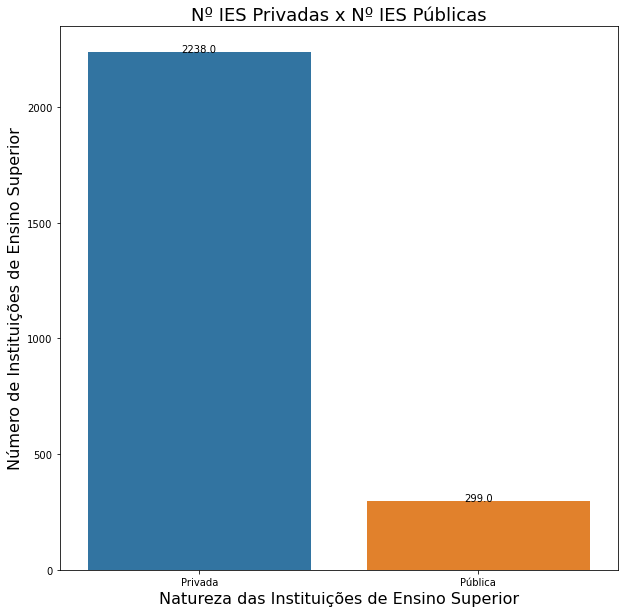

In [20]:
#Definindo o tamanho da figura
plt.figure(figsize=(10, 10))

#Plotando o gráfico com o uso do método barplot da lib seaborn
s = sn.barplot(x= ies_pub_priv_soma.index, y= ies_pub_priv_soma.values)

#Renomeando as labels dos eixos X e Y, bem como mudando o tamanho da font
plt.xlabel("Natureza das Instituições de Ensino Superior", fontdict={'fontsize':16})
plt.ylabel("Número de Instituições de Ensino Superior", fontdict={'fontsize':16})

#Criando o título do gráfico
plt.title('Nº IES Privadas x Nº IES Públicas', fontdict={'fontsize': 18})


#Colocando o rotulo de dados no gráfico e centralizado
for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center')

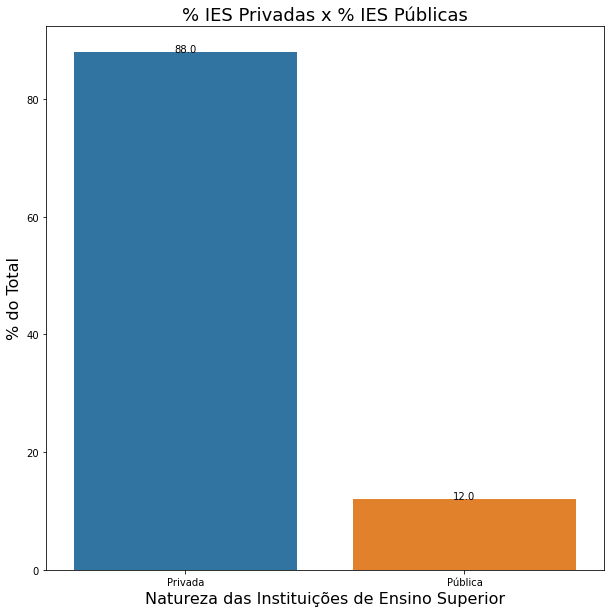

In [21]:
plt.figure(figsize=(10, 10))

#Plotando o gráfico com o uso do método barplot da lib seaborn
s = sn.barplot(x= ies_pub_priv_soma.index, y= np.around((ies_pub_priv_soma.values/ies_pub_priv_soma.values.sum()),2)*100)

#Renomeando as labels dos eixos X e Y, bem como mudando o tamanho da font
plt.xlabel("Natureza das Instituições de Ensino Superior", fontdict={'fontsize':16})
plt.ylabel("% do Total", fontdict={'fontsize':16})

#Criando o título do gráfico
plt.title('% IES Privadas x % IES Públicas', fontdict={'fontsize': 18})

#Colocando o rotulo de dados no gráfico e centralizado
for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center')

# O próximo passo então é descobrir o número de alunos matriculados no país, no ano de 2018, em IES.

In [22]:
#Abaixo realizei uma consulta a tabela DM_CURSO do banco de dados, para dela extrair diversas informações que me serão importantes.
#....Para evitar ter que fazer tratamentos posteriormente já optei por, no momento da consulta, modificar alguma informações de
#....fórmulário que eram apenas numéricas, pelos textos explicativos a eles referentes que encontrei no dicionário de dados.

query = """
SELECT DISTINCT(CO_CURSO), CO_IES, CO_LOCAL_OFERTA, CO_UF, NO_CURSO,
QT_MATRICULA_TOTAL, QT_CONCLUINTE_TOTAL, QT_INGRESSO_TOTAL,
QT_INGRESSO_VAGA_NOVA, QT_VAGA_TOTAL, QT_INSCRITO_TOTAL, 
CASE
    WHEN TP_CATEGORIA_ADMINISTRATIVA = '1' OR TP_CATEGORIA_ADMINISTRATIVA = '2' OR TP_CATEGORIA_ADMINISTRATIVA = '3' OR TP_CATEGORIA_ADMINISTRATIVA = '7' THEN 'Pública'
    ELSE 'Privada'
END AS PUB_PRIV,
CASE
    WHEN TP_ORGANIZACAO_ACADEMICA = '1' THEN 'Universidade'
    WHEN TP_ORGANIZACAO_ACADEMICA = '2' THEN 'Centro Universitário'
    WHEN TP_ORGANIZACAO_ACADEMICA = '3' THEN 'Faculdade'
    WHEN TP_ORGANIZACAO_ACADEMICA = '4' THEN 'Institutos Federais'
    WHEN TP_ORGANIZACAO_ACADEMICA = '5' THEN 'Centros Federais (CEFET)'
END AS Tipo_Instituição,
CASE
    WHEN TP_MODALIDADE_ENSINO = '1' THEN 'Presencial'
    WHEN TP_MODALIDADE_ENSINO = '2' THEN 'Curso a distância (EAD)'
END as 'Modalidade de Ensino',
CASE
    WHEN TP_NIVEL_ACADEMICO = '1' THEN 'Graduação'
    WHEN TP_NIVEL_ACADEMICO = '2' THEN 'Seqüencial de Formação Específica'
END as 'Nível Acadêmico'

FROM DM_CURSO

"""


df_cursos = pd.read_sql_query(query, db)
df_cursos

,CO_CURSO,CO_IES,CO_LOCAL_OFERTA,CO_UF,NO_CURSO,QT_MATRICULA_TOTAL,QT_CONCLUINTE_TOTAL,QT_INGRESSO_TOTAL,QT_INGRESSO_VAGA_NOVA,QT_VAGA_TOTAL,QT_INSCRITO_TOTAL,PUB_PRIV,Tipo_Instituição,Modalidade de Ensino,Nível Acadêmico
0,1,1,105340.0,51.0,DIREITO,445,76,99,92,95,3144,Pública,Universidade,Presencial,Graduação
1,2,1,105340.0,51.0,CIÊNCIAS ECONÔMICAS,344,38,120,119,121,945,Pública,Universidade,Presencial,Graduação
2,3,1,105340.0,51.0,ENGENHARIA CIVIL,266,34,53,53,55,637,Pública,Universidade,Presencial,Graduação
3,6,1,105340.0,51.0,PEDAGOGIA,326,49,98,98,100,1461,Pública,Universidade,Presencial,Graduação
4,7,1,105340.0,51.0,SERVIÇO SOCIAL,253,23,81,81,83,1449,Pública,Universidade,Presencial,Graduação
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38251,5001430,23459,1094503.0,35.0,GESTÃO COMERCIAL,34,0,36,35,36,90,Pública,Faculdade,Presencial,Graduação
38252,1458085,23700,1095191.0,35.0,ANÁLISE E DESENVOLVIMENTO DE SISTEMAS,38,0,41,40,41,156,Pública,Faculdade,Presencial,Graduação
38253,1458087,23700,1095191.0,35.0,GESTÃO DA PRODUÇÃO INDUSTRIAL,40,0,41,40,41,164,Pública,Faculdade,Presencial,Graduação
38254,1465936,23705,1095437.0,35.0,GESTÃO DE ENERGIA E EFICIÊNCIA ENERGÉTICA,33,0,41,41,41,41,Pública,Faculdade,Presencial,Graduação


In [23]:
#Abaixo fiz a contagem do número de alunos matriculados. No DataFrame df_cursos, cada linha representa um curso e nela existe
#....uma feature com a quantidade de matriculas totais naquele curso, naquela IES específica.


total_alunos_matriculados = df_cursos['QT_MATRICULA_TOTAL'].sum()

In [24]:
total_alunos_matriculados

8451748

In [302]:
total_matriculas_publicas = df_cursos[df_cursos['PUB_PRIV'] == 'Pública']['QT_MATRICULA_TOTAL'].sum()

In [304]:
total_matriculas_publicas

2077835

In [303]:
total_matriculas_privadas = df_cursos[df_cursos['PUB_PRIV'] == 'Privada']['QT_MATRICULA_TOTAL'].sum()

In [305]:
total_matriculas_privadas

6373913

In [25]:
alunos_matriculados = df_cursos.groupby('PUB_PRIV')['QT_MATRICULA_TOTAL'].sum()

In [26]:
alunos_matriculados_graduacao = df_cursos[df_cursos['Nível Acadêmico'] == 'Graduação']['QT_MATRICULA_TOTAL'].sum()

# Com a análise acima verificamos que, em 2018, haviam 2537 Instituições de Ensino Superior (IES) no país, nas quais estavam matriculados 8.451.748 alunos. Desse total 6.373.913 alunos estavam matriculados na rede Privada e 2.077.835 na rede Pública.

# Esses dados me informam que, aproximadamente, 75,42% de todas as matrículas realizadas em IES no país, em 2018, foram realizadas em Instituições Privadas, as demais 24,58% das matriculas estão em Instituições Públicas.

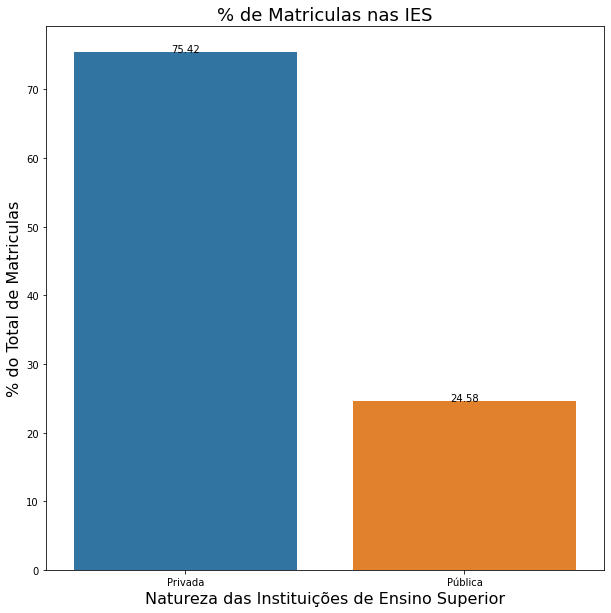

In [27]:
plt.figure(figsize=(10, 10))
s = sn.barplot(x= alunos_matriculados.index, y= np.around((alunos_matriculados.values/alunos_matriculados.values.sum()),4)*100)

plt.xlabel("Natureza das Instituições de Ensino Superior", fontdict={'fontsize':16})
plt.ylabel("% do Total de Matriculas", fontdict={'fontsize':16})

plt.title('% de Matriculas nas IES', fontdict={'fontsize': 18})

for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center')

---

# Sabemos até então que a maior quantidade de alunos está na rede privada, bem como existe um número muito superior de instituições nessa rede. No entanto, ainda se faz necessário entender melhor como funciona a divisão entre os tipos de instituição, uma vez que existem critérios estabelecidos pelo MEC que dividem os tipos de instituições entre Universidades, Centros Universitários, Faculdades, IF's e Cefet's, esses dois último são exclusivamente Públicos.

In [28]:
query = """
SELECT Tipo_Instituição, COUNT(Tipo_Instituição) as Qnt_tipo
FROM
(SELECT DISTINCT(CO_IES), NO_IES,
CASE
    WHEN TP_CATEGORIA_ADMINISTRATIVA = '1' OR TP_CATEGORIA_ADMINISTRATIVA = '2' OR TP_CATEGORIA_ADMINISTRATIVA = '3' THEN 'Pública'
    ELSE 'Privada'
END AS PUB_PRIV,
CASE
    WHEN TP_ORGANIZACAO_ACADEMICA = '1' THEN 'Universidade'
    WHEN TP_ORGANIZACAO_ACADEMICA = '2' THEN 'Centro Universitário'
    WHEN TP_ORGANIZACAO_ACADEMICA = '3' THEN 'Faculdade'
    WHEN TP_ORGANIZACAO_ACADEMICA = '4' THEN 'Institutos Federais'
    WHEN TP_ORGANIZACAO_ACADEMICA = '5' THEN 'Centros Federais (CEFET)'
    ELSE 'verificar'
END AS Tipo_Instituição
FROM DM_IES) AS tb1

GROUP BY Tipo_Instituição

"""

tipo_instituicao = pd.read_sql_query(query, db)
tipo_instituicao

,Tipo_Instituição,Qnt_tipo
0,Centro Universitário,230
1,Centros Federais (CEFET),2
2,Faculdade,2068
3,Institutos Federais,38
4,Universidade,199


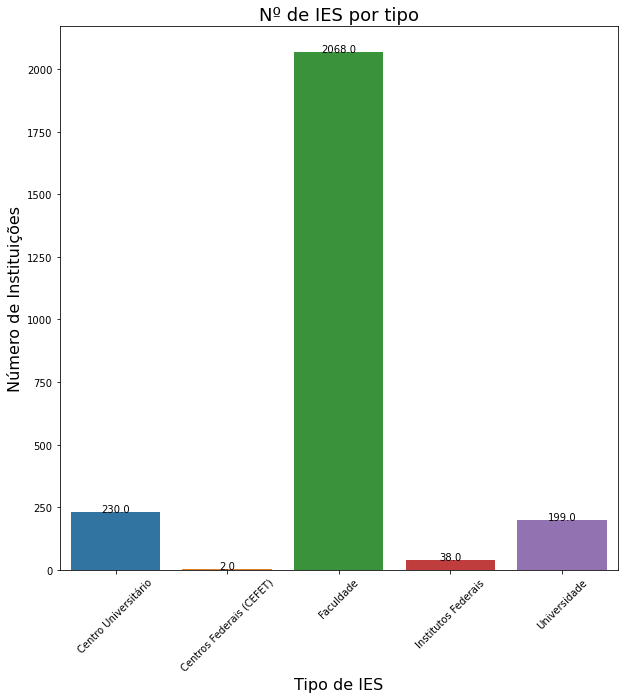

In [29]:
plt.figure(figsize=(10, 10))

s = sn.barplot(data= tipo_instituicao, x= "Tipo_Instituição",
               y= 'Qnt_tipo')

plt.xlabel("Tipo de IES", fontdict={'fontsize':16})
plt.ylabel("Número de Instituições", fontdict={'fontsize':16})
plt.xticks(rotation = 45)

plt.title('Nº de IES por tipo', fontdict={'fontsize': 18})


for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center')

In [30]:
query = """
SELECT PUB_PRIV, Tipo_Instituição, COUNT(Tipo_Instituição) as Qnt_tipo
FROM
(SELECT DISTINCT(CO_IES), NO_IES,
CASE
    WHEN TP_CATEGORIA_ADMINISTRATIVA = '1' OR TP_CATEGORIA_ADMINISTRATIVA = '2' OR TP_CATEGORIA_ADMINISTRATIVA = '3' THEN 'Pública'
    ELSE 'Privada'
END AS PUB_PRIV,
CASE
    WHEN TP_ORGANIZACAO_ACADEMICA = '1' THEN 'Universidade'
    WHEN TP_ORGANIZACAO_ACADEMICA = '2' THEN 'Centro Universitário'
    WHEN TP_ORGANIZACAO_ACADEMICA = '3' THEN 'Faculdade'
    WHEN TP_ORGANIZACAO_ACADEMICA = '4' THEN 'Institutos Federais'
    WHEN TP_ORGANIZACAO_ACADEMICA = '5' THEN 'Centros Federais (CEFET)'
    ELSE 'verificar'
END AS Tipo_Instituição
FROM DM_IES) AS tb1

GROUP BY PUB_PRIV, Tipo_Instituição

"""

tipo_instituicao_pub_priv = pd.read_sql_query(query, db)
tipo_instituicao_pub_priv

,PUB_PRIV,Tipo_Instituição,Qnt_tipo
0,Privada,Centro Universitário,220
1,Privada,Faculdade,1951
2,Privada,Universidade,92
3,Pública,Centro Universitário,10
4,Pública,Centros Federais (CEFET),2
5,Pública,Faculdade,117
6,Pública,Institutos Federais,38
7,Pública,Universidade,107


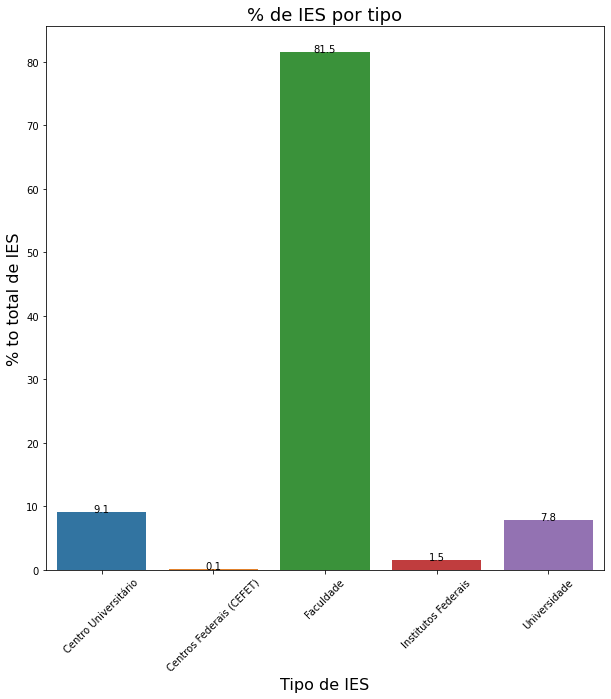

In [31]:
plt.figure(figsize=(10, 10))

s = sn.barplot(data= tipo_instituicao, x= "Tipo_Instituição",
               y= (round(tipo_instituicao["Qnt_tipo"]/tipo_instituicao["Qnt_tipo"].sum(),
               3)*100))

plt.xlabel("Tipo de IES", fontdict={'fontsize':16})
plt.ylabel("% to total de IES", fontdict={'fontsize':16})
plt.xticks(rotation = 45)

plt.title('% de IES por tipo', fontdict={'fontsize': 18})


for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center')

# Em números absolutos a maior quantidade de IES são Faculdades (2.068), seguidas muito atrás por Centros Universitários (230) e Universidades (199). Percentualmente, para termos uma melhor comparação, as Faculdades, em 2018, eram 81,5% de todas as IES do país.

# Isso se explica por ser muito menos complexo e oneroso se abrir uma Faculdade do que uma Universidades, como podemos ver no quadro comparativos abaixo que retrata as diferenças de obrigações legais entre elas:

Característica | Faculdade | Universidade
---|---|---
Portfólio de cursos | Focada em uma área determinada de conhecimento. | Possui cursos diversos, de diferentes áreas de conhecimento.
Quantidade de cursos | Por oferecer formações específicas, a quantidade de cursos é reduzida. | Por oferecer formações específicas, a quantidade de cursos é reduzida.
Por oferecer formações específicas, a quantidade de cursos é reduzida. | Deve possuir autorização do MEC. | Tem autonomia para criar cursos sem autorização prévia do MEC.
Atividade | Voltada ao ensino, mas pode ter atividades de extensão ou pesquisa. | Além do ensino, promove necessariamente atividades de extensão e pesquisa.
Pesquisa | Não tem obrigação de desenvolver pesquisas. | Deve ter produção intelectual cultural e científica.
Corpo docente | Pelo menos um terço dos professores deve ter título de especialista. Não há necessidade de dedicação integral. | Pelo menos um terço dos professores deve ter título de mestre ou doutor. Um terço do corpo docente também deve se dedicar integralmente.
Pós-graduação | Não tem obrigação de oferecer cursos de pós-graduação. | Deve ter, no mínimo, quatro programas de pós-graduação stricto sensu, sendo ao menos um deles de doutorado.
Comunidade | Não tem obrigação de se relacionar com a comunidade. | Deve criar aproximação com a comunidade e atendê-la.








# Mas  será que ao separa as IES em Públicas e Privadas as proporções entre os tipos de Instituições e mantém?

In [32]:
tipo_privadas = tipo_instituicao_pub_priv[tipo_instituicao_pub_priv['PUB_PRIV'] == 'Privada']

In [33]:
tipo_publicas = tipo_instituicao_pub_priv[tipo_instituicao_pub_priv['PUB_PRIV'] == 'Pública']

# Quando analisamos apenas o universo de IES Privadas, vemos que 86% delas são Faculdades, 10% Centros Universitários e apenas 4% Universidades. Cefet's e IF's são instituições exclusivamente públicas pela sua própria natureza, logo, corretamente não aparecem aqui.

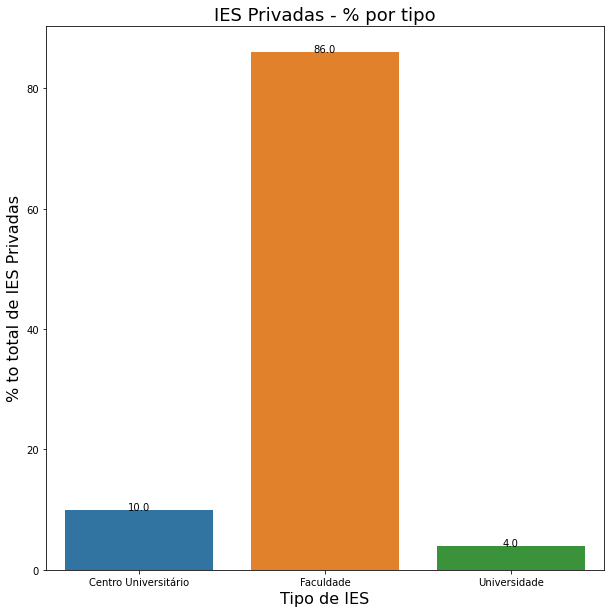

In [34]:
plt.figure(figsize=(10, 10))

s = sn.barplot(x= tipo_privadas['Tipo_Instituição'],
               y= round(tipo_privadas['Qnt_tipo']/tipo_privadas['Qnt_tipo'].sum(),2)*100)

plt.xlabel("Tipo de IES", fontdict={'fontsize':16})
plt.ylabel("% to total de IES Privadas", fontdict={'fontsize':16})

plt.title('IES Privadas - % por tipo', fontdict={'fontsize': 18})


for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center')

# Quando analisamos apenas o universo de IES Públicas, vemos que há um equilíbrio muito maior entre Faculdades (43%) e Universidades (39%).

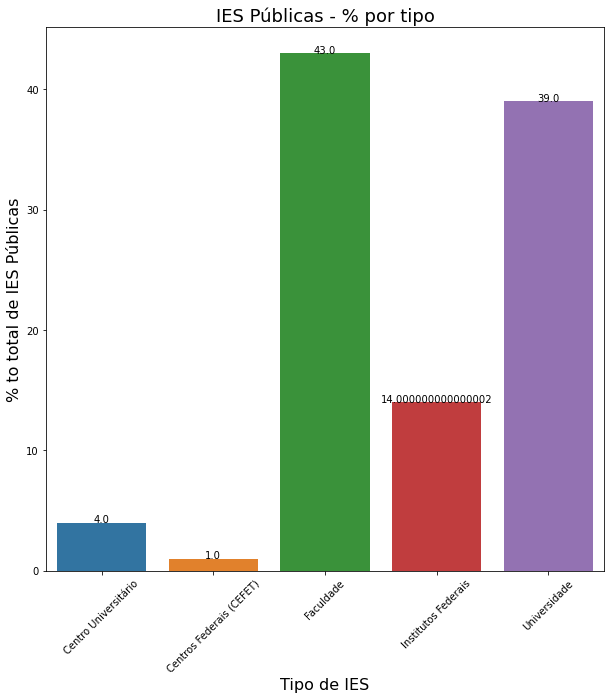

In [35]:
plt.figure(figsize=(10, 10))

s = sn.barplot(x= tipo_publicas['Tipo_Instituição'],
               y= round(tipo_publicas['Qnt_tipo']/tipo_publicas['Qnt_tipo'].sum(),2)*100)

plt.xticks(rotation = 45)
plt.xlabel("Tipo de IES", fontdict={'fontsize':16})
plt.ylabel("% to total de IES Públicas", fontdict={'fontsize':16})

plt.title('IES Públicas - % por tipo', fontdict={'fontsize': 18})


for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center')

# Com isso já temos a perfeita informação de como se dá a divisão relativa a quantidade de instituições de ensino superior existentes no país. Sabemos que em termos de quantidade de IES as Faculdades ocupam 81,5% do quadro total.

 

# Também já temos a informação que 75,42% das matriculas estão na rede privada e 24,58% na rede pública, conforme podemos ver abaixo:

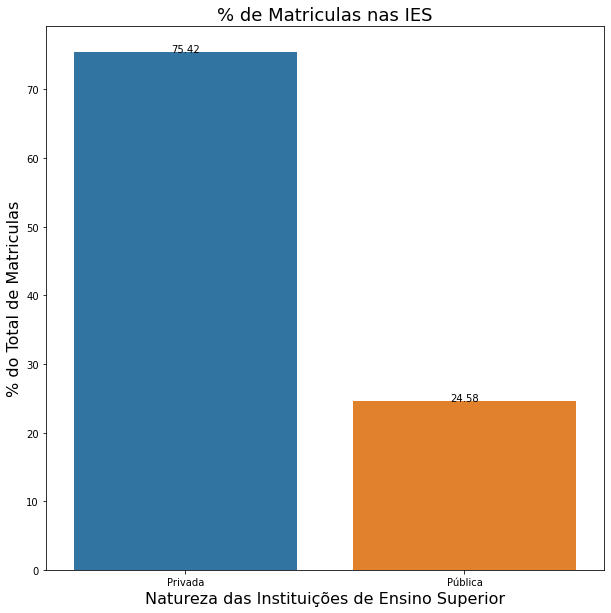

In [71]:
plt.figure(figsize=(10, 10))
s = sn.barplot(x= alunos_matriculados.index, y= np.around((alunos_matriculados.values/alunos_matriculados.values.sum()),4)*100)

plt.xlabel("Natureza das Instituições de Ensino Superior", fontdict={'fontsize':16})
plt.ylabel("% do Total de Matriculas", fontdict={'fontsize':16})

plt.title('% de Matriculas nas IES', fontdict={'fontsize': 18})

for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center')

# Mas qual será a relevância de cada tipo de instituição nesse volume de matrículas? Pois eu queso saber onde os alunos estão.

- **INFORMAÇÕES TÉCNICAS:**

Aqui fiz uma opção que precisa ser salientada. No que diz respeito as cursos existem 2 níveis acadêmicos, Graduação e Outros cursos sequenciais. Considerei apenas os dados relativos a **GRADUAÇÕES**. 

In [52]:
alunos_tipo_ies = (df_cursos[df_cursos['Nível Acadêmico'] == 'Graduação'].groupby('Tipo_Instituição')['QT_MATRICULA_TOTAL'].sum()).sort_values()
alunos_tipo_ies

Tipo_Instituição
Centros Federais (CEFET)      13799
Institutos Federais          183707
Faculdade                   1879228
Centro Universitário        1906327
Universidade                4467694
Name: QT_MATRICULA_TOTAL, dtype: int64

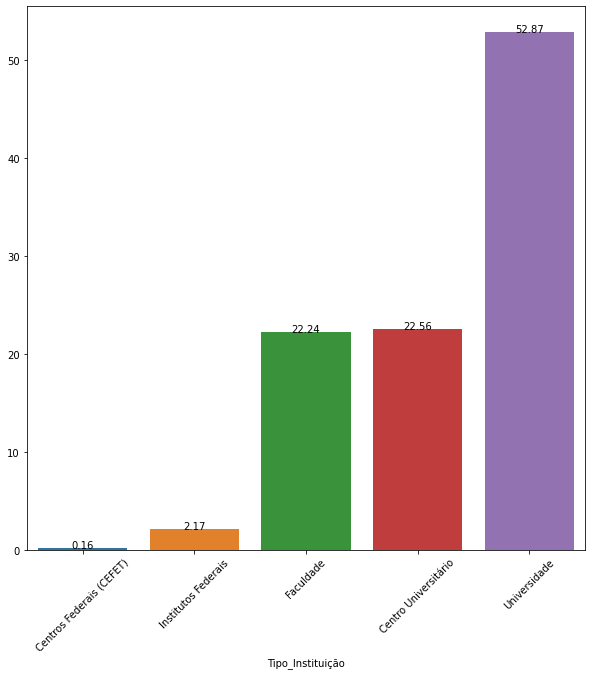

In [53]:
plt.figure(figsize=(10, 10))

s = sn.barplot(x= alunos_tipo_ies.index, y= np.around(alunos_tipo_ies.values/alunos_tipo_ies.values.sum(),4)*100)
plt.xticks(rotation = 45)

for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center')

# E aqui percebemos que embora as Universidades sejam 7,9% das IES do país, nelas se concentraram 52,87% de todas as matrículas, em contrapartida, nas Faculdades que são 81,5% das IES do país, temos apenas 22% das matrículas, aproximadamente.

# Ampliando essa análise para extratificar as matriculas por tipo de instituição entre as redes públicas e privadas, pois é uma informação importante para ententer a relevância em relação ao total de matrículas nas IES no país, encontramos o seguinte:

In [65]:
matriculas_publicas = df_cursos[(df_cursos['Nível Acadêmico'] == 'Graduação') & (df_cursos['PUB_PRIV'] == 'Pública')].groupby('Tipo_Instituição')['QT_MATRICULA_TOTAL'].sum().sort_values()
matriculas_publicas

Tipo_Instituição
Centros Federais (CEFET)      13799
Centro Universitário          23851
Faculdade                    121124
Institutos Federais          183707
Universidade                1735000
Name: QT_MATRICULA_TOTAL, dtype: int64

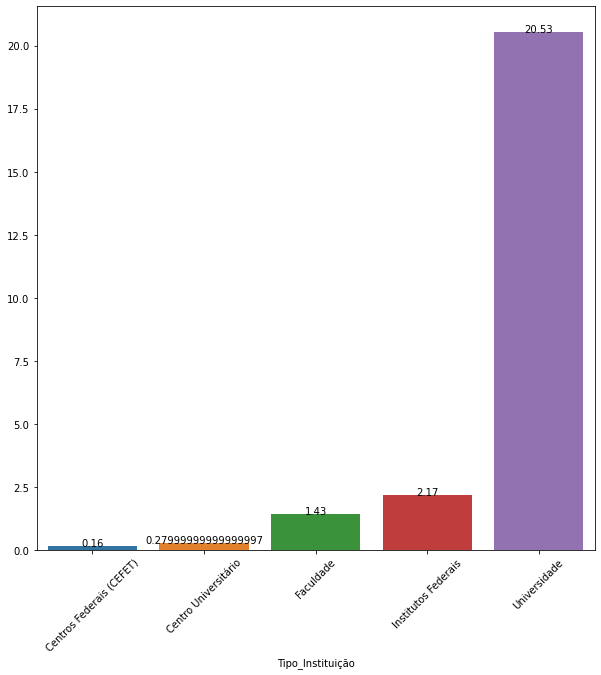

In [69]:
plt.figure(figsize=(10, 10))

s = sn.barplot(x= matriculas_publicas.index, y= np.around(matriculas_publicas.values/alunos_tipo_ies.values.sum(),4)*100)
plt.xticks(rotation = 45)

for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center')

# De todas as matriculas em IES no país, em 2018, 20,53% desses alunos estão em Universidades públicas.

In [66]:
matriculas_privadas = df_cursos[(df_cursos['Nível Acadêmico'] == 'Graduação') & (df_cursos['PUB_PRIV'] == 'Privada')].groupby('Tipo_Instituição')['QT_MATRICULA_TOTAL'].sum().sort_values()
matriculas_privadas

Tipo_Instituição
Faculdade               1758104
Centro Universitário    1882476
Universidade            2732694
Name: QT_MATRICULA_TOTAL, dtype: int64

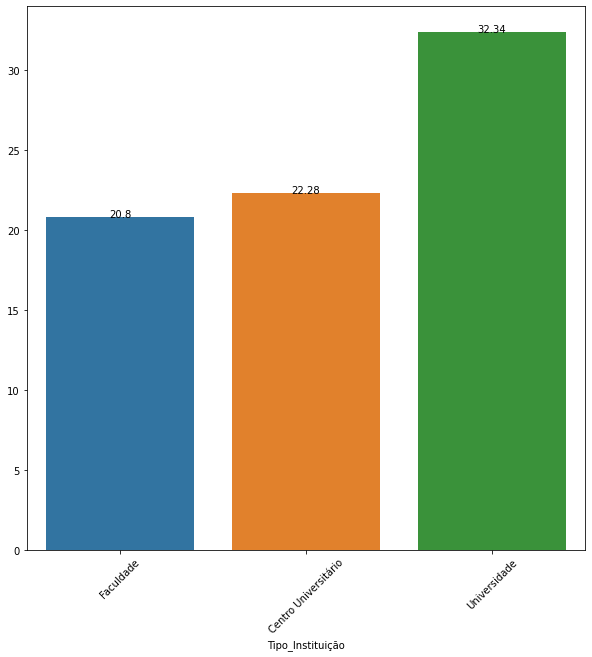

In [70]:
plt.figure(figsize=(10, 10))

s = sn.barplot(x= matriculas_privadas.index, y= np.around(matriculas_privadas.values/alunos_tipo_ies.values.sum(),4)*100)
plt.xticks(rotation = 45)

for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center')

# De todas as matriculas em IES no país, em 2018, 32,34% desses alunos estão em universidades privadas, 22,28% em centros universitários privados e, 20,8% em faculdades privadas.

# Com essa informação acima eu consigo entender claramente o tamanho do mercado de IES privadas no país como um todo.

# Essa realidade pode ou não se confirmar em todos os estados da federação, isto é o que analisaremos abaixo, observando a distribuição estado a estado:

In [75]:
query = """

SELECT temp_tab2.SIG_UF, temp_tab2.PUB_PRIV, COUNT(temp_tab2.PUB_PRIV) as Qnt_IES
FROM

(SELECT temp_tab.NO_IES, temp_tab.NO_UF, temp_tab.SIG_UF,
CASE
    WHEN temp_tab.TP_CATEGORIA_ADMINISTRATIVA = '1' OR temp_tab.TP_CATEGORIA_ADMINISTRATIVA = '2' OR temp_tab.TP_CATEGORIA_ADMINISTRATIVA = '3' THEN 'Pública'
    ELSE 'Privada'
END as PUB_PRIV
FROM 

(SELECT DISTINCT tb1.CO_UF,
        tb1.NO_IES,
        tb1.TP_CATEGORIA_ADMINISTRATIVA,
        tb1.TP_ORGANIZACAO_ACADEMICA,
        tb2.NO_UF,
        tb2.SIG_UF
FROM 
    DM_IES AS tb1
JOIN
    estados AS tb2
    
    ON tb1.CO_UF = tb2.CO_UF) as temp_tab
    ) as temp_tab2
    
GROUP BY temp_tab2.SIG_UF, temp_tab2.PUB_PRIV

"""

df_PubPriv = pd.read_sql_query(query, db) 
df_PubPriv

,SIG_UF,PUB_PRIV,Qnt_IES
0,AC,Privada,9
1,AC,Pública,2
2,AL,Privada,25
3,AL,Pública,4
4,AM,Privada,20
5,AM,Pública,3
6,AP,Privada,12
7,AP,Pública,3
8,BA,Privada,135
9,BA,Pública,10


## Agora temos uma DataFrame com o número total de universidades públicas e privadas para cada estado do Brasil para podermos analisar.

# Abaixo conseguimos analisar detalhadamente a presença de instituições privadas e públicas em cada estado da federação. É possível perceber há alguns estados onde o número de IES privadas se destaca, por ser muito supeior aos demais estados, Obviamente há que se levar em conta a demanda existente em cada estado, o que podemos começar a mensurar analisando a população local, no entanto só pelo gráfico abaixo podemos tirar algumas conclusões.

# Temos estados como MG em que o número de IES privadas é 14 vezes maior do que o de públicas, bem como em outros, como RR esse número é de apenas 1.5 vezes maior.

# Temos IES públicas em todos os estados do país, bem como não há em nenhum deles presença de IES públicas maior do que o de privadas, o que é algo que já imaginávamos, mas aqui se confirma.

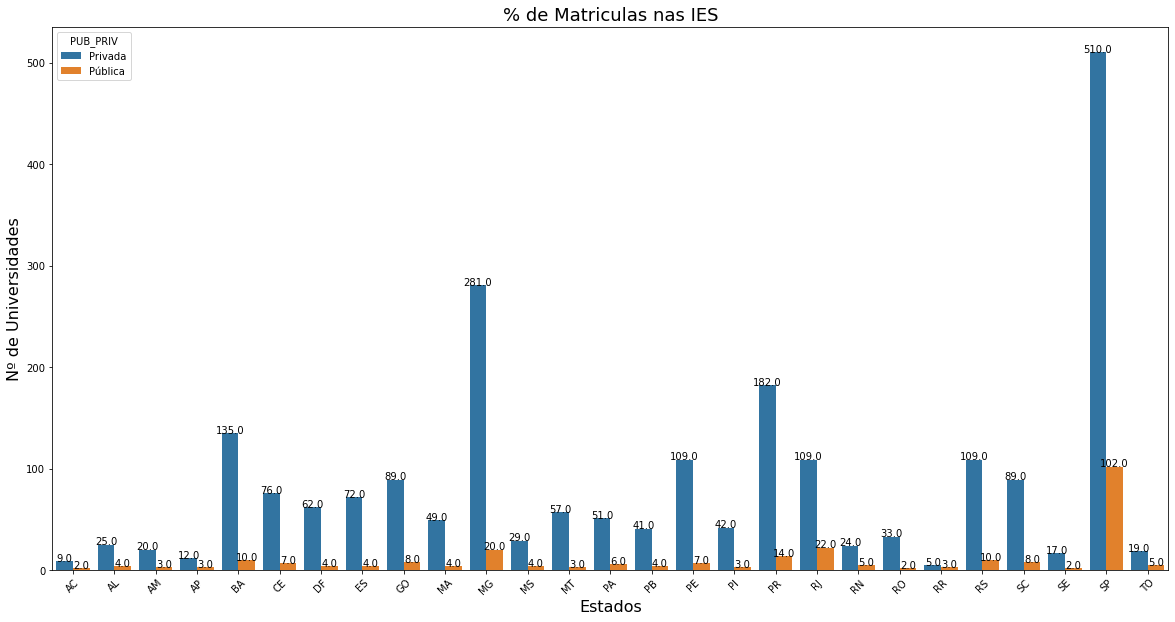

In [142]:
plt.figure(figsize=(20, 10))

s = sn.barplot(x= df_PubPriv.SIG_UF, y= df_PubPriv.Qnt_IES, hue= df_PubPriv.PUB_PRIV)
plt.xlabel("Estados", fontdict={'fontsize':16})
plt.ylabel("Nº de Universidades", fontdict={'fontsize':16})

plt.title('% de Matriculas nas IES', fontdict={'fontsize': 18})
               
plt.xticks(rotation = 45)

for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center')

# A partir desse momento vamos buscar informações da demanda entre os cursos, tendo por base a tabela DM_CURSO que nos traz todas as informações referentes a matriculas no país, no ano de 2018.

In [290]:
#Abaixo fiz uma consulta ao banco de dados, na qual utilizei o conceito de subquerys, pois fiz uma primeira consulta a qual
#....em sequência encapsulei. Essa tabela de retorno fiz um join com a tabela de Estados para obter a Sigla e nome dos estados
#....em substituição ao mero código, pois essa informaçãoe ra de difícil compreensão.
#....Por fim nessa query modifiquei diversos valores que anteriormente estavam em códigos pelos textos que cada código representa
#....bem como limitei a consulta à apenas os cursos presenciais. Isso foi feito, pois os cursos a distância não tem valores na
#....coluna CO_UF, o que atrapalhava minha busca. Como retorno tenho uma tabela com todos os cursos presenciais do país e, dentre
#....outras informações o estado onde cada curso se localiza e o número de matrículas.


query = """

SELECT
    tb_temp.CO_CURSO,
    tb_temp.CO_IES,
    ESTADOS.SIG_UF,
    ESTADOS.NO_UF,
    tb_temp.NO_CURSO,
    tb_temp.QT_MATRICULA_TOTAL,
    tb_temp.PUB_PRIV,
    tb_temp.Tipo_Instituicao,
    tb_temp.NU_ANO_CENSO,
    tb_temp.QT_INGRESSO_TOTAL,
    tb_temp.QT_INGRESSO_VAGA_NOVA,
    tb_temp.QT_INSCRITO_TOTAL,
    tb_temp.QT_CONCLUINTE_TOTAL,
    tb_temp.QT_VAGAS_NOVAS_INTEGRAL,
    tb_temp.QT_VAGAS_NOVAS_MATUTINO,
    tb_temp.QT_VAGAS_NOVAS_VESPERTINO,
    tb_temp.QT_VAGAS_NOVAS_NOTURNO,
    tb_temp.QT_VAGAS_NOVAS_EAD,
    tb_temp.QT_INSC_VAGA_NOVA_INTEGRAL,
    tb_temp.QT_INSC_VAGA_NOVA_MATUTINO,
    tb_temp.QT_INSC_VAGA_NOVA_VESPERTINO,
    tb_temp.QT_INSC_VAGA_NOVA_NOTURNO,
    tb_temp.QT_INSC_VAGA_NOVA_EAD

FROM
(SELECT
    DISTINCT CO_CURSO,
    CO_IES,
    CO_UF,
    NO_CURSO,
    QT_MATRICULA_TOTAL,
    NU_ANO_CENSO,
    QT_INGRESSO_TOTAL,
    QT_INGRESSO_VAGA_NOVA,
    QT_INSCRITO_TOTAL,
    QT_CONCLUINTE_TOTAL,
    QT_VAGAS_NOVAS_INTEGRAL,
    QT_VAGAS_NOVAS_MATUTINO,
    QT_VAGAS_NOVAS_VESPERTINO,
    QT_VAGAS_NOVAS_NOTURNO,
    QT_VAGAS_NOVAS_EAD,
    QT_INSC_VAGA_NOVA_INTEGRAL,
    QT_INSC_VAGA_NOVA_MATUTINO,
    QT_INSC_VAGA_NOVA_VESPERTINO,
    QT_INSC_VAGA_NOVA_NOTURNO,
    QT_INSC_VAGA_NOVA_EAD,

CASE
    WHEN TP_CATEGORIA_ADMINISTRATIVA = '1' OR TP_CATEGORIA_ADMINISTRATIVA = '2' OR TP_CATEGORIA_ADMINISTRATIVA = '3' THEN 'Pública'
    ELSE 'Privada'
END as PUB_PRIV,
CASE
    WHEN TP_ORGANIZACAO_ACADEMICA = '1' THEN 'Universidade'
    WHEN TP_ORGANIZACAO_ACADEMICA = '2' THEN 'Centro Universitário'
    WHEN TP_ORGANIZACAO_ACADEMICA = '3' THEN 'Faculdade'
    WHEN TP_ORGANIZACAO_ACADEMICA = '4' THEN 'Institutos Federais'
    WHEN TP_ORGANIZACAO_ACADEMICA = '5' THEN 'Centros Federais (CEFET)'
    ELSE 'verificar'
END AS Tipo_Instituicao,
CASE
    WHEN TP_MODALIDADE_ENSINO = '1' THEN 'Presencial'
    ELSE 'Curso a distância (EAD)'
END as Modalidade_Ensino
FROM DM_CURSO

WHERE Modalidade_Ensino = 'Presencial' AND TP_NIVEL_ACADEMICO = '1') as tb_temp

JOIN
    ESTADOS
    ON ESTADOS.CO_UF = tb_temp.CO_UF


"""
cursos_graduacao_presenciais = pd.read_sql_query(query, db) 

In [292]:
pd.set_option('display.max_columns', 80)
cursos_graduacao_presenciais.head()

,CO_CURSO,CO_IES,SIG_UF,NO_UF,NO_CURSO,QT_MATRICULA_TOTAL,PUB_PRIV,Tipo_Instituicao,NU_ANO_CENSO,QT_INGRESSO_TOTAL,QT_INGRESSO_VAGA_NOVA,QT_INSCRITO_TOTAL,QT_CONCLUINTE_TOTAL,QT_VAGAS_NOVAS_INTEGRAL,QT_VAGAS_NOVAS_MATUTINO,QT_VAGAS_NOVAS_VESPERTINO,QT_VAGAS_NOVAS_NOTURNO,QT_VAGAS_NOVAS_EAD,QT_INSC_VAGA_NOVA_INTEGRAL,QT_INSC_VAGA_NOVA_MATUTINO,QT_INSC_VAGA_NOVA_VESPERTINO,QT_INSC_VAGA_NOVA_NOTURNO,QT_INSC_VAGA_NOVA_EAD
0,9409,450,RO,Rondônia,CIÊNCIAS CONTÁBEIS,191,Privada,Centro Universitário,2018,12,11,109,19,NaN,NaN,NaN,106.0,None,NaN,NaN,NaN,92.0,None
1,9411,450,RO,Rondônia,ADMINISTRAÇÃO,237,Privada,Centro Universitário,2018,80,80,112,22,NaN,NaN,NaN,114.0,None,NaN,NaN,NaN,101.0,None
2,9412,450,RO,Rondônia,DIREITO,991,Privada,Centro Universitário,2018,185,181,610,97,NaN,NaN,62.0,141.0,None,NaN,NaN,130.0,426.0,None
3,9413,450,RO,Rondônia,AGRONOMIA,230,Privada,Centro Universitário,2018,27,27,146,26,NaN,NaN,103.0,NaN,None,NaN,NaN,139.0,NaN,None
4,9414,450,RO,Rondônia,SISTEMAS DE INFORMAÇÃO,189,Privada,Centro Universitário,2018,10,10,91,6,NaN,NaN,NaN,101.0,None,NaN,NaN,NaN,85.0,None


- **INFORMAÇÃO TÉCNICA**
Os DataFrames cursos_graduacao_presenciais e cursos_graduacao_ead serão a base de nossas análises exploratórias daqui para frente

In [287]:
#Abaixo fiz o agrupamento por nome do curso e, para cada um dos agrupamentos, somei os valores da feature que representava a
#....quantidade de matriculas, por fim ordenei esse somatório de forma decrescente para assim ter um Serie com a quantidade de
#....matriculas no pais curso a curso, do que teve mais matrículas para o que teve menos. Guardei essa Serie em uma variável
#....para facilitar a manipulação na célula onde proteio gráfico

total_matriculas_presenciais = cursos_graduacao_presenciais.groupby('NO_CURSO')['QT_MATRICULA_TOTAL'].sum().sort_values(ascending=False)

In [299]:
cursos_graduacao_presenciais[cursos_graduacao_presenciais['PUB_PRIV'] == 'Privada'].groupby('NO_CURSO')['QT_MATRICULA_TOTAL'].sum().sort_values(ascending=False)

NO_CURSO
DIREITO                                                                  782502
ADMINISTRAÇÃO                                                            358564
ENFERMAGEM                                                               257525
ENGENHARIA CIVIL                                                         250510
PSICOLOGIA                                                               235428
                                                                          ...  
TECNÓLOGO EM METALURGIA                                                       0
GESTÃO DE EMPREENDIMENTOS ESPORTIVOS                                          0
COMUNICAÇÃO PARA WEB                                                          0
PRODUÇÃO DE GRÃOS                                                             0
FORMAÇÃO PEDAGÓGICA DE DOCENTES PARA A EDUCAÇÃO BÁSICA E PROFISSIONAL         0
Name: QT_MATRICULA_TOTAL, Length: 434, dtype: int64

# Abaixo temos os 50 cursos com maior número de alunos matriculados no Brasil em 2018.

# Cursos tradicionais como Direito, Administração, Engenharia Civil, Enfermagem, Pedagogia, Psicologia, Contábeis, Educação Física, Fisioterapia e Medicina, continuam sendo os 10 cursos com maior numero de alunos, nesta ordem que foram apresentados.

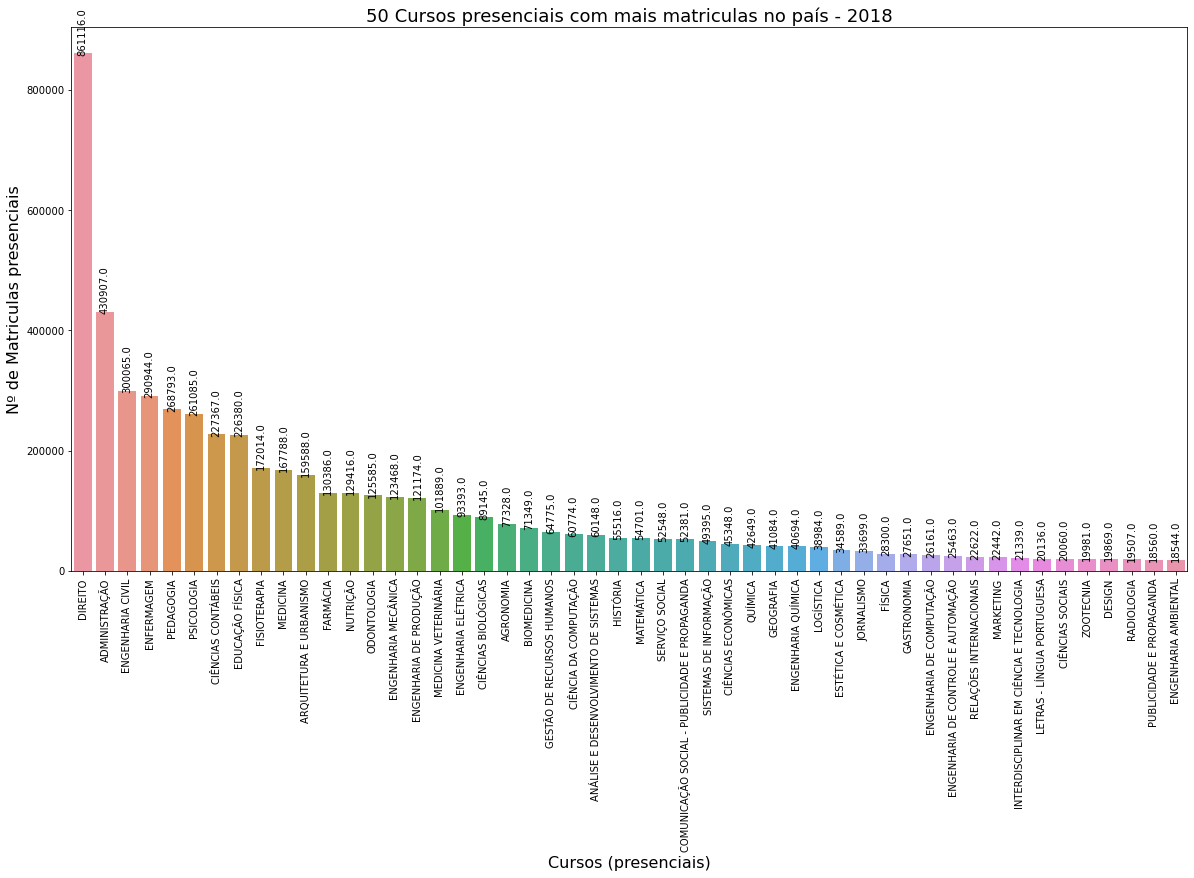

In [268]:
plt.figure(figsize=(20, 10))

s = sn.barplot(x= total_matriculas_presenciais.sort_values(ascending=False).head(50).index, y= total_matriculas_presenciais.sort_values(ascending=False).head(50).values)

plt.xlabel("Cursos (presenciais)", fontdict={'fontsize':16})
plt.ylabel("Nº de Matriculas presenciais", fontdict={'fontsize':16})

plt.title('50 Cursos presenciais com mais matriculas no país - 2018', fontdict={'fontsize': 18})
               
plt.xticks(rotation = 90)

for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center', rotation = 90)

# Abaixo fiz a mesma análise presente no gráfico anterior, no entanto separei apenas as matriculas realizadas em IES privadas. Assim conseguimos ver se há uma diferença entre os cursos que vem sendo mais demandados nas IES privadas, em relação ao quadro geral do país.

# Direito, Administração, Enfermagem e Eng. Civil, continuam sendo os cursos mais procurados, ratificando o que haviamos visto ao analisar o numero total de matriculas não segregadas por rede de ensino. Tivemos apenas uma alteração na ordem entre Enfermagem e Eng. Civil.


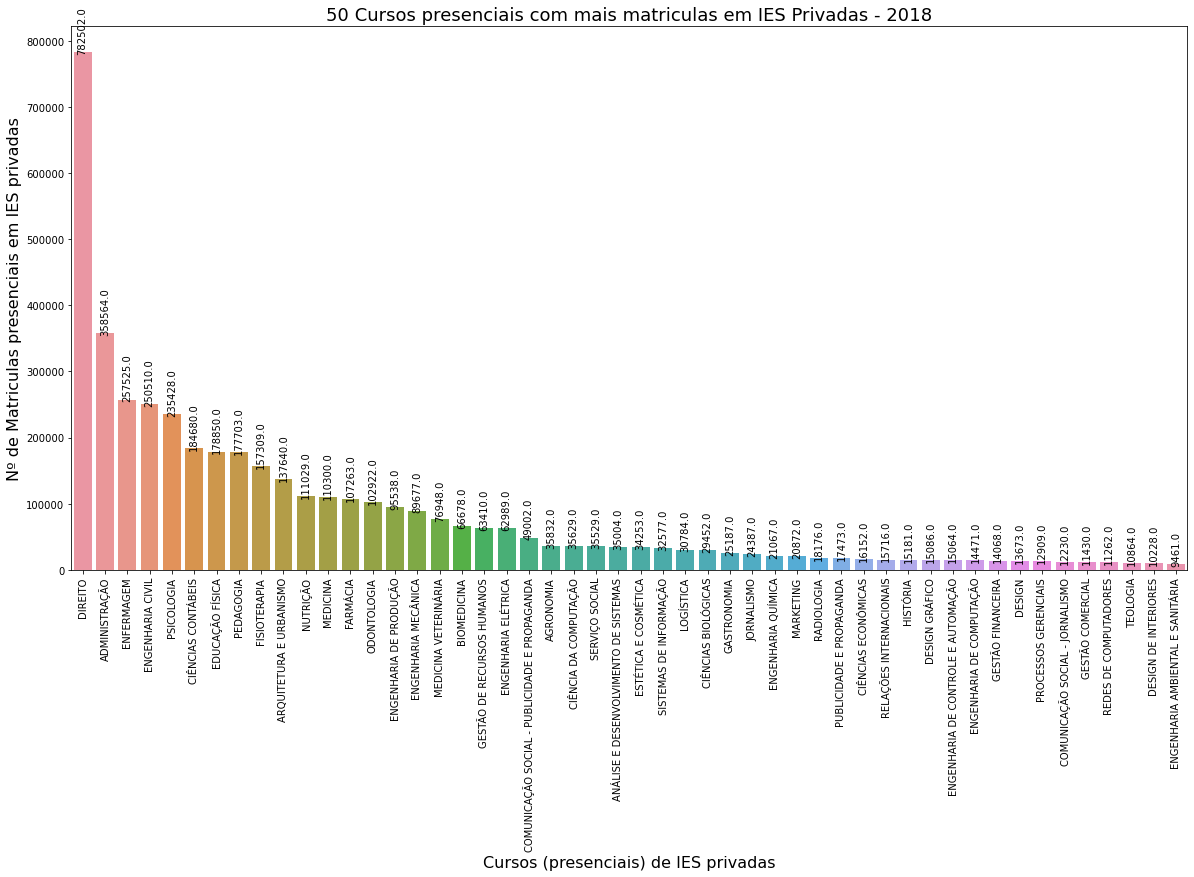

In [301]:
plt.figure(figsize=(20, 10))

s = sn.barplot(x= cursos_graduacao_presenciais[cursos_graduacao_presenciais['PUB_PRIV'] == 'Privada'].groupby('NO_CURSO')['QT_MATRICULA_TOTAL'].sum().sort_values(ascending=False).sort_values(ascending=False).head(50).index, y= cursos_graduacao_presenciais[cursos_graduacao_presenciais['PUB_PRIV'] == 'Privada'].groupby('NO_CURSO')['QT_MATRICULA_TOTAL'].sum().sort_values(ascending=False).sort_values(ascending=False).head(50).values)

plt.xlabel("Cursos (presenciais) de IES privadas", fontdict={'fontsize':16})
plt.ylabel("Nº de Matriculas presenciais em IES privadas", fontdict={'fontsize':16})

plt.title('50 Cursos presenciais com mais matriculas em IES Privadas - 2018', fontdict={'fontsize': 18})
               
plt.xticks(rotation = 90)

for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center', rotation = 90)

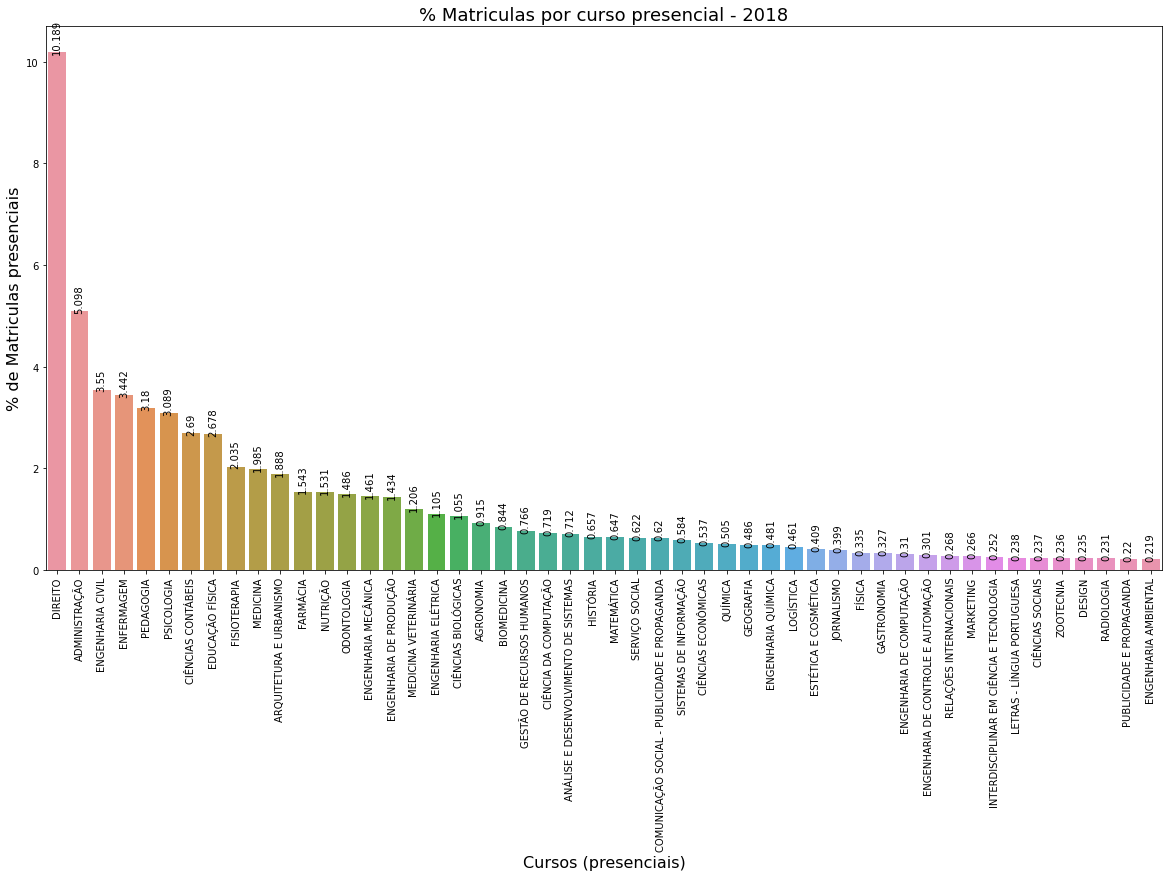

In [334]:
plt.figure(figsize=(20, 10))

s = sn.barplot(x= total_matriculas_presenciais.sort_values(ascending=False).head(50).index, 
    y= np.around((total_matriculas_presenciais.sort_values(ascending=False).head(50).values/total_alunos_matriculados)*100,3))

plt.xlabel("Cursos (presenciais)", fontdict={'fontsize':16})
plt.ylabel("% de Matriculas presenciais", fontdict={'fontsize':16})

plt.title('% Matriculas por curso presencial - 2018', fontdict={'fontsize': 18})
               
plt.xticks(rotation = 90)

for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center', rotation = 90)

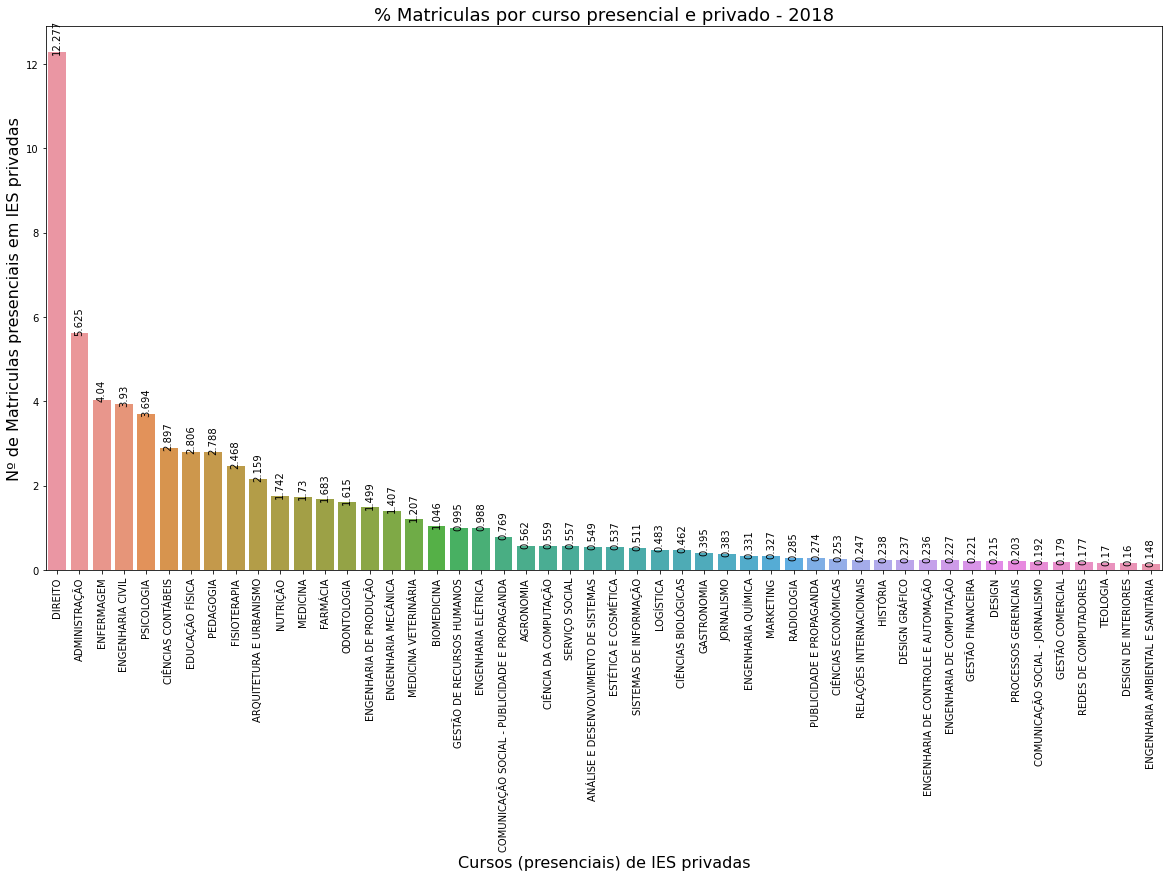

In [333]:
plt.figure(figsize=(20, 10))

s = sn.barplot(x= cursos_graduacao_presenciais[cursos_graduacao_presenciais['PUB_PRIV'] == 'Privada'].groupby('NO_CURSO')['QT_MATRICULA_TOTAL'].sum().sort_values(ascending=False).sort_values(ascending=False).head(50).index,
    y= np.around((cursos_graduacao_presenciais[cursos_graduacao_presenciais['PUB_PRIV'] == 'Privada'].groupby('NO_CURSO')['QT_MATRICULA_TOTAL'].sum().sort_values(ascending=False).sort_values(ascending=False).head(50).values/total_matriculas_privadas)*100,3))

plt.xlabel("Cursos (presenciais) de IES privadas", fontdict={'fontsize':16})
plt.ylabel("Nº de Matriculas presenciais em IES privadas", fontdict={'fontsize':16})

plt.title('% Matriculas por curso presencial e privado - 2018', fontdict={'fontsize': 18})
               
plt.xticks(rotation = 90)

for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center', rotation = 90)

# Analisando apenas as novas matriculas

In [288]:
total_matriculas_novas_presenciais = cursos_graduacao_presenciais.groupby('NO_CURSO')['QT_INGRESSO_VAGA_NOVA'].sum().sort_values(ascending=False)

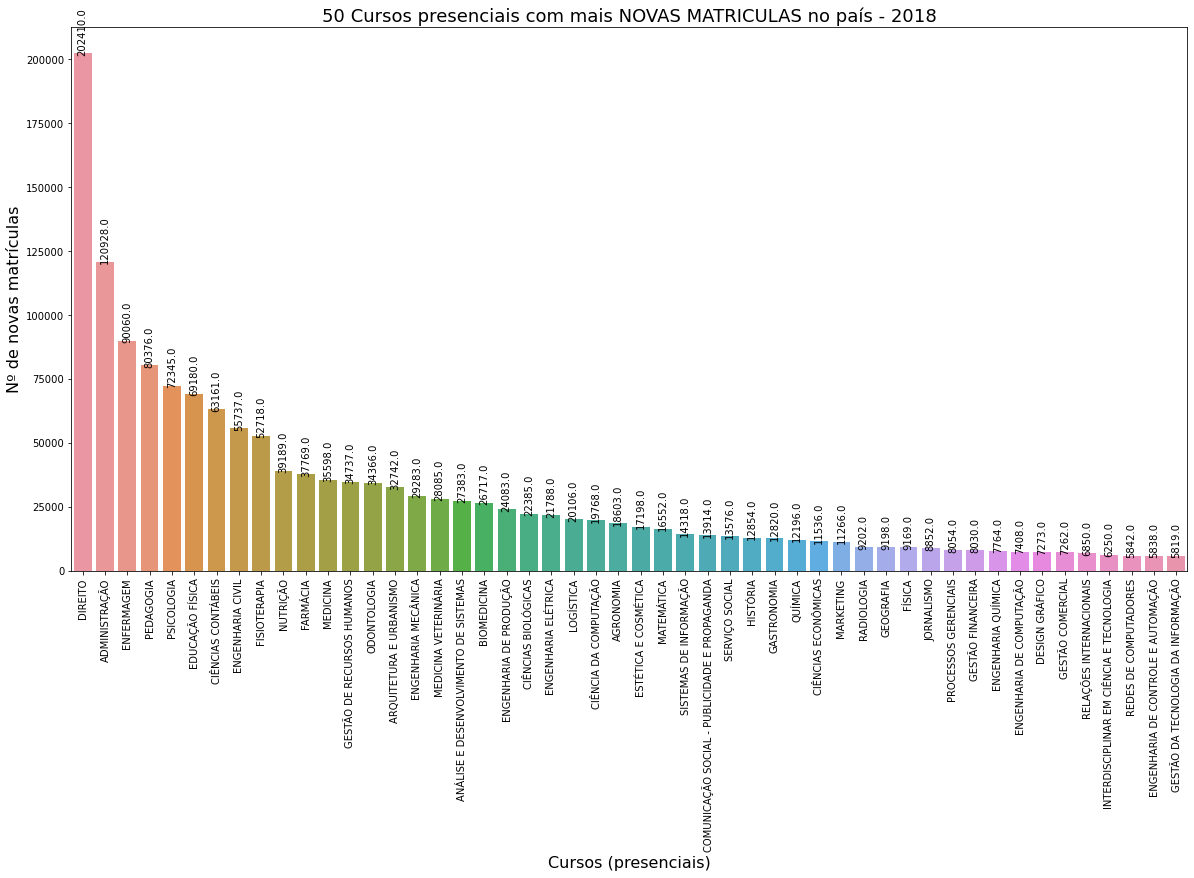

In [289]:
plt.figure(figsize=(20, 10))

s = sn.barplot(x= total_matriculas_novas_presenciais.sort_values(ascending=False).head(50).index, y= total_matriculas_novas_presenciais.sort_values(ascending=False).head(50).values)

plt.xlabel("Cursos (presenciais)", fontdict={'fontsize':16})
plt.ylabel("Nº de novas matrículas", fontdict={'fontsize':16})

plt.title('50 Cursos presenciais com mais NOVAS MATRICULAS no país - 2018', fontdict={'fontsize': 18})
               
plt.xticks(rotation = 90)

for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center', rotation = 90)

# Matriculas totais por curso, separadas estado a estado

In [270]:
cursos_graduacao_presenciais.groupby(['SIG_UF', 'NO_CURSO'])['QT_MATRICULA_TOTAL'].sum()

SIG_UF  NO_CURSO                             
AC      ABI - CIÊNCIAS SOCIAIS                    38
        ADMINISTRAÇÃO                            983
        AGROECOLOGIA                             174
        AGROINDÚSTRIA                             69
        ANÁLISE E DESENVOLVIMENTO DE SISTEMAS     88
                                                ... 
TO      SISTEMAS PARA INTERNET                   204
        TEATRO                                   283
        TURISMO                                    0
        TURISMO PATRIMONIAL E SOCIOAMBIENTAL     107
        ZOOTECNIA                                624
Name: QT_MATRICULA_TOTAL, Length: 4674, dtype: int64

# Analise cursos EAD

# Pelo gráfico acima conseguimos ver claramente como se dá a distribuição das instituições de ensino superior no país. Quando analisamos a quantidade de IES públicas vemos uma uniformidade muito maior na distribuição, pois é dever do Estado prover essa educação, o unico ponto fora da curva é SP estado que tem aproximente 21% da população total do país), no entanto foi contemplado com quase 38% da IES públicas.

# Já quando avaliamos as IES privadas vemos que, apesar de presentes em todos os estados da federação, há uma preferência muito maior por

In [628]:
populacao_estado = {'AC': 733559,'AL': 3120494,'AP': 669526,'AM': 108181,'BA': 14016906,
              'CE': 8452381,'DF': 2570160,'ES': 3514952,'GO': 6003788,
              'MA': 6574789,'MT': 3035122,'MS': 2839188,'MG': 19597330,
              'PR': 10444526,'PB': 3766528,'PA': 7581051,'PE': 8796448,
              'PI': 3118360,'RJ': 15989929,'RN': 3168027,'RS': 10693929,
              'RO': 1562409,'RR': 450479,'SC': 6248436,'SE': 2068017,
              'SP': 41262199,'TO': 1383445}

pib_estado = {'AC': 15630,'AL': 58964,'AP': 17497,'AM': 108181,'BA': 293241,
              'CE': 163575,'DF': 273614,'ES': 137346,'GO': 208672,
              'MA': 97340,'MT': 142122,'MS': 106943,'MG': 651873,
              'PR': 466377,'PB': 67986,'PA': 178377,'PE': 197853,
              'PI': 52781,'RJ': 779928,'RN': 71337,'RS': 482464,
              'RO': 47091,'RR': 14292,'SC': 323264,'SE': 44689,
              'SP': 2348338,'TO': 39356}

In [606]:
df_PubPriv_pib = pd.DataFrame(df_PubPriv_pib.groupby('SIG_UF')['Qnt_Universidades'].sum())

In [613]:
df_PubPriv_pib

,Qnt_Universidades
SIG_UF,
AC,11
AL,29
AM,23
AP,15
BA,145
CE,83
DF,66
ES,76
GO,97


In [644]:
df_PubPriv_pib['PIB'] = df_PubPriv_pib.index.map(pib_estado)

In [640]:
df_PubPriv_pib['População'] = df_PubPriv_pib.index.map(populacao_estado)

In [655]:
estados_top7_pib = pd.DataFrame(df_PubPriv_pib['PIB'].sort_values(ascending=False).head(7))
estados_top7_pib

,PIB
SIG_UF,
SP,2348338
RJ,779928
MG,651873
RS,482464
PR,466377
SC,323264
BA,293241


In [656]:
estados_top7_populacao = pd.DataFrame(df_PubPriv_pib['População'].sort_values(ascending=False).head(7))
estados_top7_populacao

,População
SIG_UF,
SP,41262199
MG,19597330
RJ,15989929
BA,14016906
RS,10693929
PR,10444526
PE,8796448


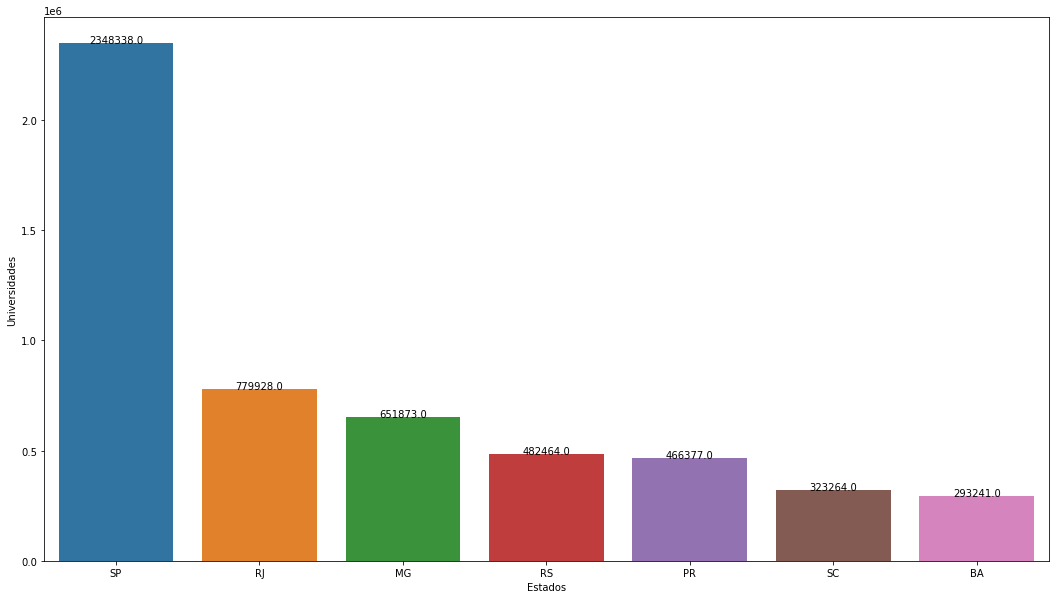

In [659]:
plt.figure(figsize=(18, 10))                  #ajustando o tamanho da figura
s = sn.barplot(data= estados_top7_pib, x = estados_top7_pib.index, y = 'PIB')
plt.xlabel("Estados")
plt.ylabel("Universidades")

for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center')

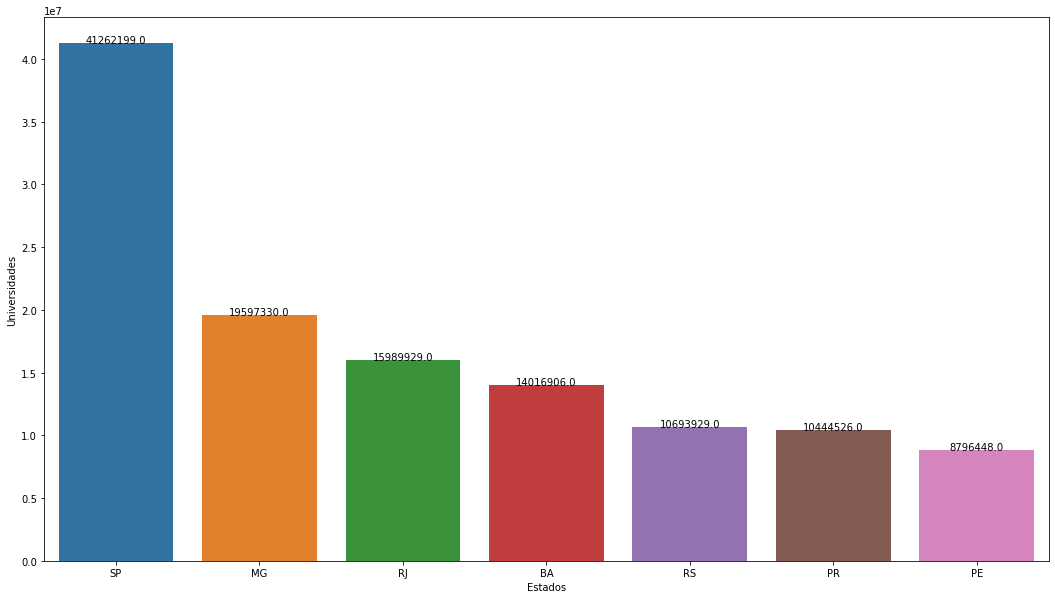

In [660]:
plt.figure(figsize=(18, 10))                  #ajustando o tamanho da figura
s = sn.barplot(data= estados_top7_populacao, x = estados_top7_populacao.index, y = 'População')
plt.xlabel("Estados")
plt.ylabel("Universidades")

for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center')

# Do total de cursos de educação superior existentes no país quantos são presenciais e quantos são EAD?


In [453]:
# Verificando que não existem rows com dados totalmente identicos, logo, não existem cursos de uma mesma instituição de ensino
#....duplicados nessa lista

df_CURSO.duplicated().sum()

0

In [455]:
#Precisei modificar os tipos das colunas CO_CURSO e CO_IES, pois eu quero fazer uma combinação entre elas e não uma soma, como
#....ambas são do tipo 'int' caso ou tive um CO_CURSO = 1 e um CO_IES = 1, da forma como estão agora o somatório entre elas será
#....2, mas eu quero uma combinação entre os valores que me dê 11, para isso eu preciso inicialmente mudar os tipos para 'object'

df_CURSO.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38256 entries, 0 to 38255
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CO_CURSO               38256 non-null  object 
 1   CO_IES                 38256 non-null  object 
 2   CO_LOCAL_OFERTA        35076 non-null  float64
 3   CO_UF                  35076 non-null  float64
 4   NO_CURSO               38256 non-null  object 
 5   QT_MATRICULA_TOTAL     38256 non-null  int64  
 6   QT_CONCLUINTE_TOTAL    38256 non-null  int64  
 7   QT_INGRESSO_TOTAL      38256 non-null  int64  
 8   QT_INGRESSO_VAGA_NOVA  38256 non-null  int64  
 9   QT_VAGA_TOTAL          38256 non-null  int64  
 10  QT_INSCRITO_TOTAL      38256 non-null  int64  
 11  PUB_PRIV               38256 non-null  object 
 12  Tipo_Instituição       38256 non-null  object 
 13  Modalidade de Ensino   38256 non-null  object 
 14  Nível Acadêmico        38256 non-null  object 
 15  ID

In [412]:
df_CURSO = df_CURSO.astype({'CO_CURSO':'str',
                                     'CO_IES': 'str'})

In [413]:
df_CURSO.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38256 entries, 0 to 38255
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CO_CURSO               38256 non-null  object 
 1   CO_IES                 38256 non-null  object 
 2   CO_LOCAL_OFERTA        35076 non-null  float64
 3   CO_UF                  35076 non-null  float64
 4   NO_CURSO               38256 non-null  object 
 5   QT_MATRICULA_TOTAL     38256 non-null  int64  
 6   QT_CONCLUINTE_TOTAL    38256 non-null  int64  
 7   QT_INGRESSO_TOTAL      38256 non-null  int64  
 8   QT_INGRESSO_VAGA_NOVA  38256 non-null  int64  
 9   QT_VAGA_TOTAL          38256 non-null  int64  
 10  QT_INSCRITO_TOTAL      38256 non-null  int64  
 11  PUB_PRIV               38256 non-null  object 
 12  Tipo_Instituição       38256 non-null  object 
 13  Modalidade de Ensino   38256 non-null  object 
 14  Nível Acadêmico        38256 non-null  object 
 15  ID

In [417]:
df_CURSO['ID curso/ies'] = df_CURSO['CO_CURSO'].str.cat(df_CURSO['CO_IES'],sep="")

In [419]:
df_CURSO.head()

,CO_CURSO,CO_IES,CO_LOCAL_OFERTA,CO_UF,NO_CURSO,QT_MATRICULA_TOTAL,QT_CONCLUINTE_TOTAL,QT_INGRESSO_TOTAL,QT_INGRESSO_VAGA_NOVA,QT_VAGA_TOTAL,QT_INSCRITO_TOTAL,PUB_PRIV,Tipo_Instituição,Modalidade de Ensino,Nível Acadêmico,ID curso/ies
0,1,1,105340.0,51.0,DIREITO,445,76,99,92,95,3144,Pública,Universidade,Presencial,Graduação,11
1,2,1,105340.0,51.0,CIÊNCIAS ECONÔMICAS,344,38,120,119,121,945,Pública,Universidade,Presencial,Graduação,21
2,3,1,105340.0,51.0,ENGENHARIA CIVIL,266,34,53,53,55,637,Pública,Universidade,Presencial,Graduação,31
3,6,1,105340.0,51.0,PEDAGOGIA,326,49,98,98,100,1461,Pública,Universidade,Presencial,Graduação,61
4,7,1,105340.0,51.0,SERVIÇO SOCIAL,253,23,81,81,83,1449,Pública,Universidade,Presencial,Graduação,71


In [456]:
#Conferi que não há nenhuma duplicação, logo, posso continuar com a análise.

df_CURSO['ID curso/ies'].duplicated().sum()

0

In [467]:
df_CURSO_graduacao = df_CURSO[df_CURSO['Nível Acadêmico'] == 'Graduação']

In [469]:
presencial_EAD = df_CURSO_graduacao.groupby(['Modalidade de Ensino'])['NO_CURSO'].count()

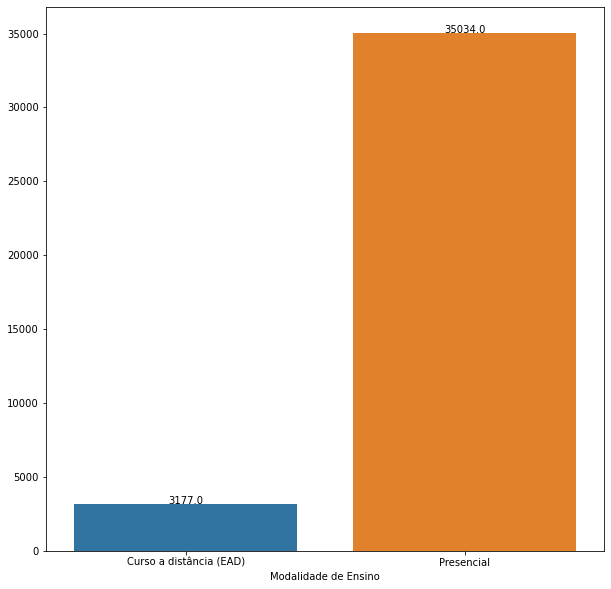

In [462]:
plt.figure(figsize=(10, 10))

s = sn.barplot(x= presencial_EAD.index, y= presencial_EAD.values)

for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center')

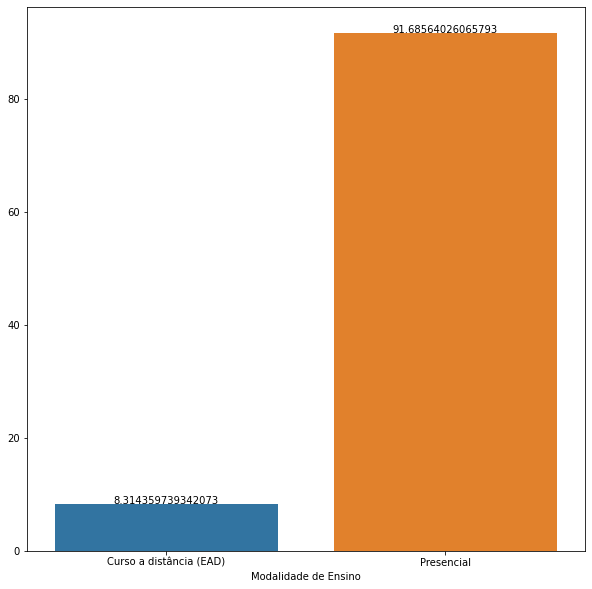

In [676]:
plt.figure(figsize=(10, 10))

s = sn.barplot(x= presencial_EAD.index, y= (presencial_EAD.values/presencial_EAD.values.sum())*100)

for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center')

# Mas será que essa enorme diferença nos mostra a tendência, uma vez que a cada dia vemos mais cursos EAD pelo país?

In [470]:
qnt_matriculas = df_CURSO_graduacao.groupby(['Modalidade de Ensino'])['QT_MATRICULA_TOTAL'].sum()
qnt_matriculas

Modalidade de Ensino
Curso a distância (EAD)    2056511
Presencial                 6394244
Name: QT_MATRICULA_TOTAL, dtype: int64

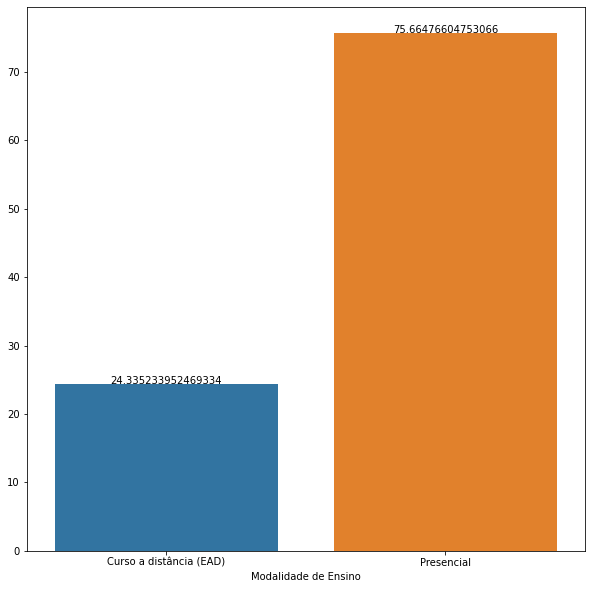

In [466]:
plt.figure(figsize=(10, 10))

s = sn.barplot(x= qnt_matriculas.index, y= (qnt_matriculas.values/qnt_matriculas.values.sum())*100)

for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center')

# O que podemos observar pelo gráfico acima é que, embora já saibamos que os cursos EAD, em 2018, fossem apenas 8,3% do total de Cursos de Ensino Superior ofertados no país, o valume de matrículas nesse ano para esses cursos já correspondiam a 24,3% do número total de matrículas do país.

In [286]:
#Abaixo fiz uma query que modifica diversos valores que anteriormente estavam em códigos pelos textos que cada código representa
#....bem como limitei a consulta à apenas os cursos EAD. Como retorno tenho uma tabela com todos os cursos EAD do país e, dentre
#....outras informações o número de matrículas.

query = """

SELECT
    DISTINCT CO_CURSO,
    CO_IES,
    NO_CURSO,
    QT_MATRICULA_TOTAL,
    NU_ANO_CENSO,
    QT_INGRESSO_TOTAL,
    QT_INGRESSO_VAGA_NOVA,
    QT_INSCRITO_TOTAL,
    QT_CONCLUINTE_TOTAL,
    
CASE
    WHEN TP_CATEGORIA_ADMINISTRATIVA = '1' OR TP_CATEGORIA_ADMINISTRATIVA = '2' OR TP_CATEGORIA_ADMINISTRATIVA = '3' THEN 'Pública'
    ELSE 'Privada'
END as PUB_PRIV,
CASE
    WHEN TP_ORGANIZACAO_ACADEMICA = '1' THEN 'Universidade'
    WHEN TP_ORGANIZACAO_ACADEMICA = '2' THEN 'Centro Universitário'
    WHEN TP_ORGANIZACAO_ACADEMICA = '3' THEN 'Faculdade'
    WHEN TP_ORGANIZACAO_ACADEMICA = '4' THEN 'Institutos Federais'
    WHEN TP_ORGANIZACAO_ACADEMICA = '5' THEN 'Centros Federais (CEFET)'
    ELSE 'verificar'
END AS Tipo_Instituição,
CASE
    WHEN TP_MODALIDADE_ENSINO = '1' THEN 'Presencial'
    ELSE 'Curso a distância (EAD)'
END as 'Modalidade_Ensino'
FROM DM_CURSO

WHERE Modalidade_Ensino = 'Curso a distância (EAD)' AND TP_NIVEL_ACADEMICO = '1'

"""
cursos_graduacao_ead = pd.read_sql_query(query, db) 
cursos_graduacao_ead

,CO_CURSO,CO_IES,NO_CURSO,QT_MATRICULA_TOTAL,NU_ANO_CENSO,QT_INGRESSO_TOTAL,QT_INGRESSO_VAGA_NOVA,QT_INSCRITO_TOTAL,QT_CONCLUINTE_TOTAL,PUB_PRIV,Tipo_Instituição,Modalidade_Ensino
0,105652,1,PEDAGOGIA,216,2018,26,26,26,0,Pública,Universidade,Curso a distância (EAD)
1,105654,1,ADMINISTRAÇÃO,0,2018,0,0,0,0,Pública,Universidade,Curso a distância (EAD)
2,114386,1,CIÊNCIAS NATURAIS E MATEMÁTICA,318,2018,17,17,17,0,Pública,Universidade,Curso a distância (EAD)
3,1113617,1,ADMINISTRAÇÃO PÚBLICA,193,2018,25,25,25,11,Pública,Universidade,Curso a distância (EAD)
4,1202871,1,LETRAS - PORTUGUÊS E INGLÊS,66,2018,0,0,0,65,Pública,Universidade,Curso a distância (EAD)
...,...,...,...,...,...,...,...,...,...,...,...,...
3172,1386387,18637,GESTÃO COMERCIAL,49,2018,49,49,450,0,Privada,Faculdade,Curso a distância (EAD)
3173,1370482,19512,GESTÃO DE RECURSOS HUMANOS,14,2018,14,14,25,0,Privada,Faculdade,Curso a distância (EAD)
3174,1370858,19512,ANÁLISE E DESENVOLVIMENTO DE SISTEMAS,8,2018,8,8,22,0,Privada,Faculdade,Curso a distância (EAD)
3175,1370866,19512,CIÊNCIAS CONTÁBEIS,14,2018,14,14,34,0,Privada,Faculdade,Curso a distância (EAD)


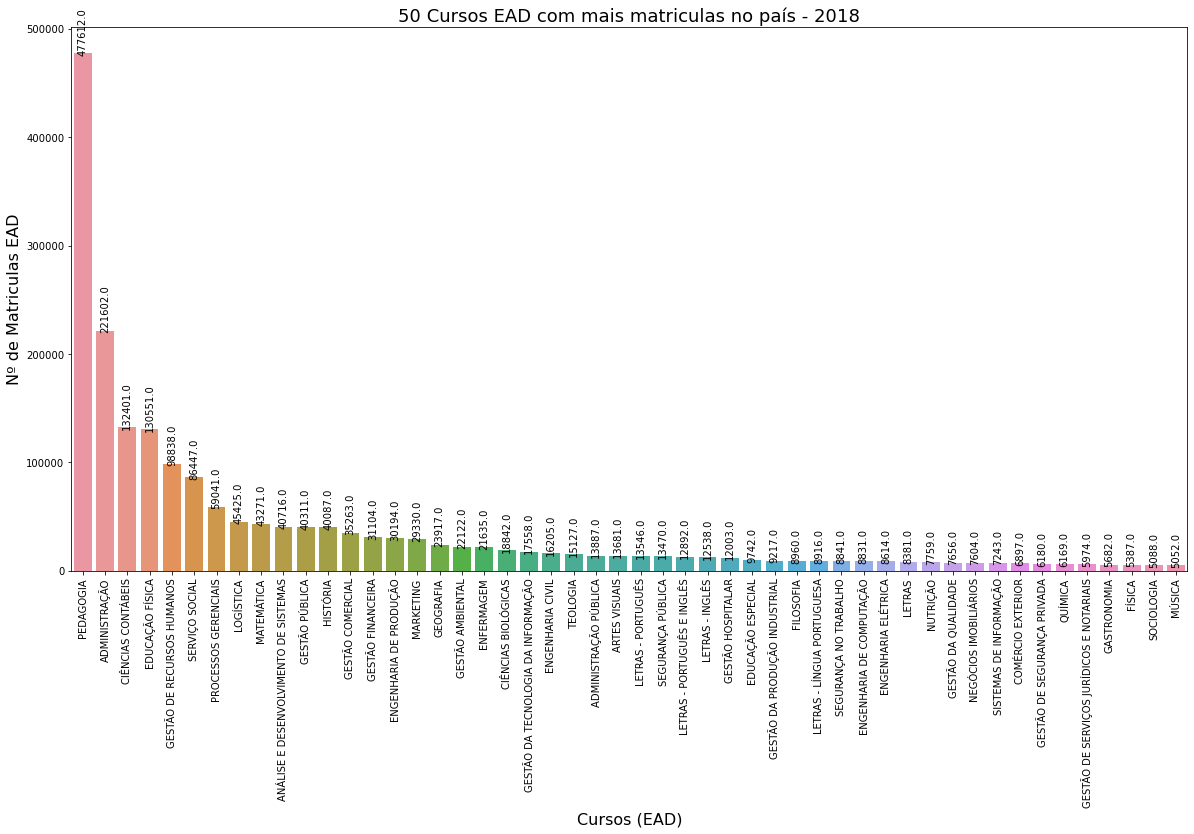

In [294]:
plt.figure(figsize=(20, 10))

s = sn.barplot(x= cursos_graduacao_ead.groupby('NO_CURSO')['QT_MATRICULA_TOTAL'].sum().sort_values(ascending=False).head(50).index, y= cursos_graduacao_ead.groupby('NO_CURSO')['QT_MATRICULA_TOTAL'].sum().sort_values(ascending=False).head(50).values)

plt.xlabel("Cursos (EAD)", fontdict={'fontsize':16})
plt.ylabel("Nº de Matriculas EAD", fontdict={'fontsize':16})

plt.title('50 Cursos EAD com mais matriculas no país - 2018', fontdict={'fontsize': 18})
               
plt.xticks(rotation = 90)

for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center', rotation = 90)

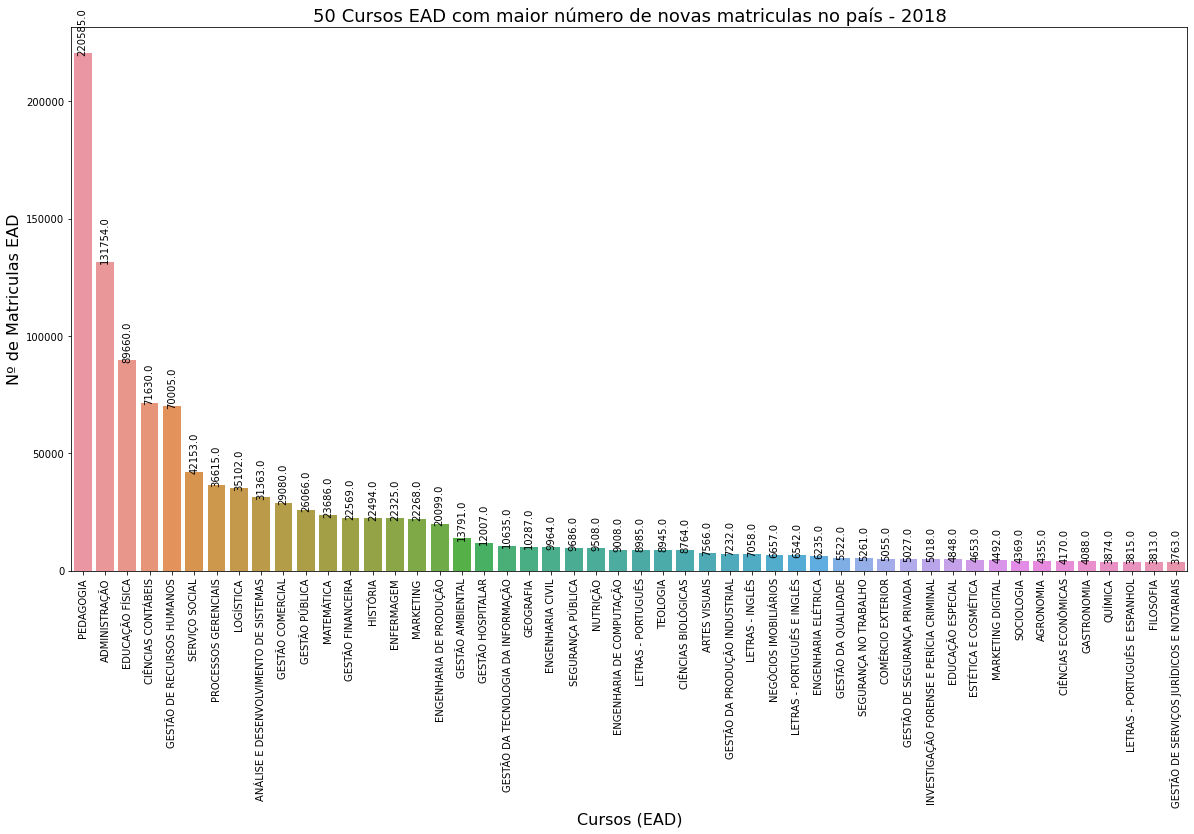

In [339]:
plt.figure(figsize=(20, 10))

s = sn.barplot(x= cursos_graduacao_ead.groupby('NO_CURSO')['QT_INGRESSO_VAGA_NOVA'].sum().sort_values(ascending=False).head(50).index,
y= cursos_graduacao_ead.groupby('NO_CURSO')['QT_INGRESSO_VAGA_NOVA'].sum().sort_values(ascending=False).head(50).values)

plt.xlabel("Cursos (EAD)", fontdict={'fontsize':16})
plt.ylabel("Nº de Matriculas EAD", fontdict={'fontsize':16})

plt.title('50 Cursos EAD com maior número de novas matriculas no país - 2018', fontdict={'fontsize': 18})
               
plt.xticks(rotation = 90)

for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center', rotation = 90)

# Mas será que esse crescimento de matriculas em curso EAD está resultando em um crescimento no número de graduandos?

# Cursos EAD e cursos EAD com mais matriculas

In [496]:
total_cursos_EAD.sort_values(ascending=False).head(50)

NO_CURSO
PEDAGOGIA                                228
ADMINISTRAÇÃO                            177
GESTÃO DE RECURSOS HUMANOS               151
CIÊNCIAS CONTÁBEIS                       132
PROCESSOS GERENCIAIS                     117
LOGÍSTICA                                101
GESTÃO FINANCEIRA                         99
MATEMÁTICA                                92
MARKETING                                 91
GESTÃO COMERCIAL                          85
EDUCAÇÃO FÍSICA                           79
HISTÓRIA                                  77
GESTÃO PÚBLICA                            73
ANÁLISE E DESENVOLVIMENTO DE SISTEMAS     65
GEOGRAFIA                                 56
GESTÃO AMBIENTAL                          56
CIÊNCIAS BIOLÓGICAS                       53
ENGENHARIA DE PRODUÇÃO                    53
SERVIÇO SOCIAL                            50
ADMINISTRAÇÃO PÚBLICA                     48
ENGENHARIA CIVIL                          44
GESTÃO DA TECNOLOGIA DA INFORMAÇÃO        41
F

# Ao ver essa lista uma curiosidade que tive foi quanto ao curso de Direito, por ser um curso muito popular imaginei que o mesmo estivesse nessa lista acima, no entanto esse não apareceu, ao fazer uma consulta específica vi que não existe nenhum curso EAD de Direito no DataSet.

In [488]:
df_CURSO_graduacao[(df_CURSO_graduacao['NO_CURSO'] == 'DIREITO') & df_CURSO_graduacao['Modalidade de Ensino'] == 'Curso a distância (EAD)']['NO_CURSO'].count()

0

# Com essa informação em mãos fui buscar mais informações e descobri que em 2018 o curso de direito não estava na lista dos cursos EAD autorizados pelo MEC.

# Quais cursos EAD mais tiveram matrículas em 2018?

In [499]:
matriculas_ead = df_CURSO_graduacao[df_CURSO_graduacao['Modalidade de Ensino'] == 'Curso a distância (EAD)'].groupby('NO_CURSO')['QT_MATRICULA_TOTAL'].sum().sort_values(ascending=False)

In [508]:
matriculas_ead.sum()

2056511

In [509]:
matriculas_ead_top50 = pd.DataFrame(matriculas_ead.head(50))

In [515]:
matriculas_ead_top50['% Matriculas Total'] = round(matriculas_ead_top50['QT_MATRICULA_TOTAL']/(matriculas_ead.sum()),4)*100

In [518]:
matriculas_ead_top50

,QT_MATRICULA_TOTAL,% Matriculas Total
NO_CURSO,,
PEDAGOGIA,477612,23.22
ADMINISTRAÇÃO,221602,10.78
CIÊNCIAS CONTÁBEIS,132401,6.44
EDUCAÇÃO FÍSICA,130551,6.35
GESTÃO DE RECURSOS HUMANOS,98838,4.81
SERVIÇO SOCIAL,86447,4.20
PROCESSOS GERENCIAIS,59041,2.87
LOGÍSTICA,45425,2.21
MATEMÁTICA,43271,2.10


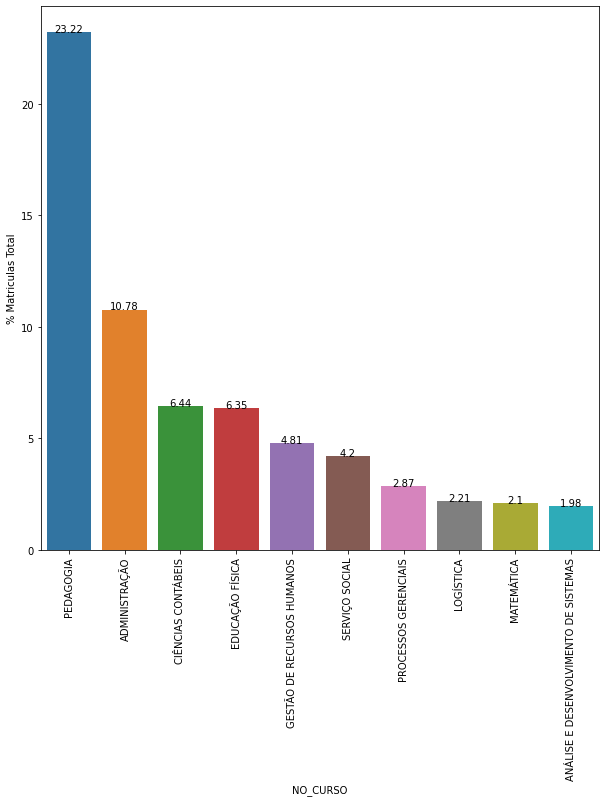

In [674]:
plt.figure(figsize=(10, 10))

s = sn.barplot(x= matriculas_ead_top50.head(10).index, y= round(matriculas_ead_top50['% Matriculas Total'].head(10),4))
plt.xticks(rotation = 90)

for i in s.patches:
    s.annotate(i.get_height(), (i.get_x() + i.get_width()/2, i.get_height()),
                 ha= 'center')

# 4) A afirmação a seguir é verdadeira: Alunos da região Norte têm maior tendência a não concluírem os cursos quando comparados ao restante do país? Comprove com dados.

In [685]:
#Foram cridos 2 dicionários para auxiliar na resolução da questão

regiao = {1: 'NORTE',
          2: 'NORDESTE',
          3: 'SULDESTE',
          4: 'SUL',
          5: 'CENTRO OESTE'}

TP_SITUACAO = {2: 'Cursando',
               3: 'Matrícula trancada',
               4: 'Desvinculado do curso',
               5: 'Transferido para outro curso da mesma IES',
               6: 'Formado',
               7: 'Falecido'}

In [686]:
query = """
SELECT
DM_IES.CO_REGIAO,
COUNT(*) AS Qt_alunos_concluintes
FROM
    DM_ALUNO
LEFT JOIN
    DM_IES
    ON DM_ALUNO.CO_IES = DM_IES.CO_IES
WHERE TP_SITUACAO IN (6)
GROUP BY CO_REGIAO

    
"""

df_alunos = pd.read_sql(query, db)
df_alunos.head()

,CO_REGIAO,Qt_alunos_concluintes
0,1,445506
1,2,1309842
2,3,4043418
3,4,1931470
4,5,696722


# Crie uma variável que represente a taxa de abandono para cada curso. É correto afirmar professores mais/menos capacitados influenciam tal taxa?





# Quais os cursos com maior crescimento de matriculas por região? E quais os com maior queda? Como você explicaria isso.



# Se você tivesse que abrir um curso (apenas um curso de graduação), qual seria, onde ele seria, qual a modalidade?



# Selecione um curso à sua escolha. Para este curso, considerando a taxa de abandono calculada no exerício 5, considere uma classe de 100 alunos. Além disso, considere que, para o curso se pagar, a turma deve terminar com, pelo menos, 60 alunos. Para cada aluno abaixo dos 60 alunos que desistir, o prejuízo será de 1000 reais. Assim sendo, calcule:

    - A probabilidade de a turma gerar prejuízo
    - O risco financeiro deste curso